**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Aprendizaje Automático**

**Segundo Semestre 2025**

**Profesor:** Dr. Luis-Alexander Calvo-Valverde

---

**Trabajo Práctico:** 2

**Datos de la entrega:** Jueves 23 de octubre 2025, a más tardar a las 6:00 pm

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo jupyter (`.ipynb`) y todos los archivos adicionales que se requieran para correr su cuaderno (en un archivo comprimido).

---

**Estudiantes:**
- David Alberto Guevara Sánchez
- Kenneth Barboza Corrales

# Nota Introductoria.

Usted puede cambiar los datasets que se le proporcionan por otros de su interés; pero de hacerlo, se le recomienda valorarlo con el profesor para que sus datasets no le agreguen una complicación importante al Trabajo Práctico.

___

# Parte 1 - Regresión (50 puntos)

___

# Introducción

Considere:
- Se le proporciona un conjunto de datos (diamonds), si desea conocer un poco de los atributos puede consultar en: <https://www.kaggle.com/datasets/shivam2503/diamonds>
- Note que en la página proporcionada se mencionan más atributos de los que contiene el archivo facilitado.
- El objetivo de esta parte es ver como el estudiante se enfrenta al proceso de pre-procesamiento, selección de atributos, predicción y evaluación. Por eso es muy importante que documente en este cuaderno sus decisiones, eso se tomará muy en cuenta en la evaluación de su respuesta.
- El atributo a predecir en regresión se denomina: price.
- Debe comentar ampliamente su código

In [53]:
from __future__ import annotations

import math
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from pandas import DataFrame, Series
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, root_mean_squared_error, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder,StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    classification_report, confusion_matrix, RocCurveDisplay
)


sns.set_theme(style="whitegrid")
set_config(transform_output="pandas")

### 1 (5 puntos)
- Cargue el archivo.
- Utilice las herramientas (gráficos, funciones que describen contenido o características de las variables, etc) que considere necesarias para analizar los atributos que tiene el dataset y ver si tiene valores faltantes, valores atípicos, etc.
- Comente sus conclusiones sobre los atributos.

---

En el siguiente bloque de código leemos el archivo `diamonds.csv` como un `DataFrame` de nombre `df`. Adicionalmente, convertimos la variable `cut` a tipo categórico para facilitar su análisis.

In [ ]:
df = pd.read_csv("./data/diamonds.csv")
df["cut"] = df["cut"].astype("category")

**Nota:** en el archivo original la variable `cut` está codificada con valores enteros del 0 al 4. Al convertirla en categórica mantenemos esa codificación, pero conservamos un listado de etiquetas descriptivas para emplearlas en los gráficos. También utilizamos una variable `column_labels` para mapear los nombres de las columnas a etiquetas más descriptivas.

In [ ]:
cut_labels = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
cut_order = df["cut"].cat.categories.tolist()

column_labels = {
    "carat": "Quilates (carat)",
    "depth": "Profundidad (%)",
    "table": "Tabla (%)",
    "x": "Largo (mm)",
    "y": "Ancho (mm)",
    "z": "Altura (mm)",
    "price": "Precio (USD)",
}

Con el siguiente bloque de código podemos observar que el `DataFrame` tiene 53940 filas, ninguna de las cuales contiene valores nulos.

In [ ]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   carat   53940 non-null  float64 
 1   depth   53940 non-null  float64 
 2   table   53940 non-null  float64 
 3   price   53940 non-null  int64   
 4   x       53940 non-null  float64 
 5   y       53940 non-null  float64 
 6   z       53940 non-null  float64 
 7   cut     53940 non-null  category
dtypes: category(1), float64(6), int64(1)
memory usage: 2.9 MB


Con el siguiente bloque de código podemos observar las primeras 5 filas del `DataFrame`.

In [ ]:
df.head(5)

,carat,depth,table,price,x,y,z,cut
0,0.23,61.5,55.0,326,3.95,3.98,2.43,4
1,0.21,59.8,61.0,326,3.89,3.84,2.31,3
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1
3,0.29,62.4,58.0,334,4.20,4.23,2.63,3
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1


#### Mapa de correlaciones

El primer gráfico que vamos a generar es uno para observar la correlación entre los atributos del `DataFrame`.

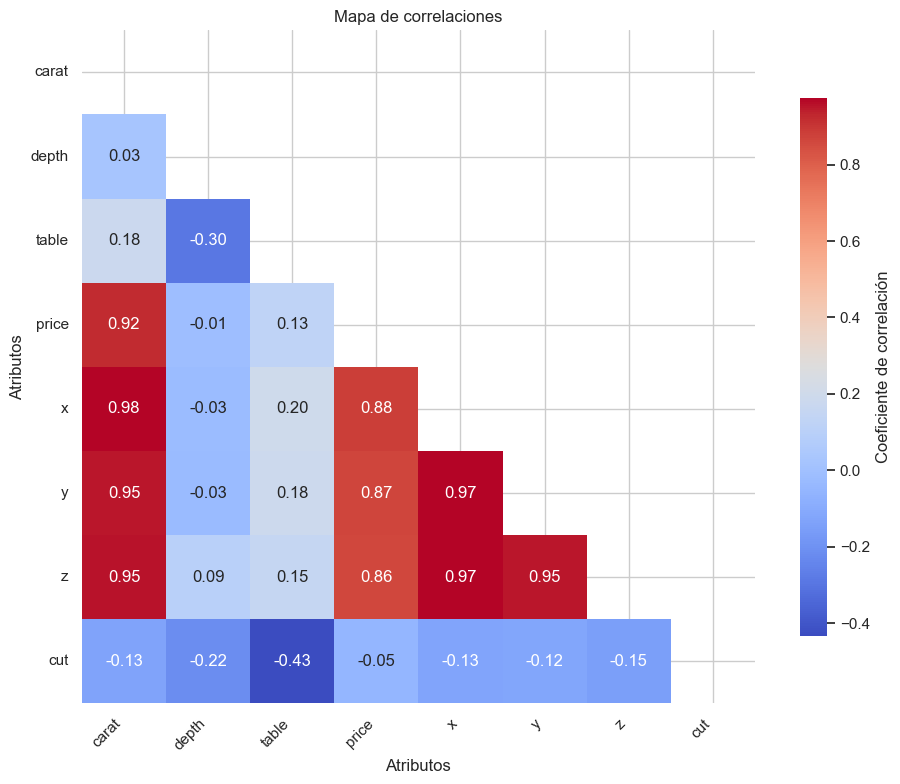

In [ ]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"label": "Coeficiente de correlación", "shrink": 0.8},
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Mapa de correlaciones")
plt.xlabel("Atributos")
plt.ylabel("Atributos")
plt.tight_layout()
plt.show()

Con este gráfico podemos observar que los atributos `x`, `y` y `z` (las dimensiones del diamante) están altamente correlacionados entre sí y con `carat` (el peso del diamante). Además, `carat` tiene una alta correlación con `price` (el precio del diamante). Esto tiene sentido, ya que los diamantes están formados de un mismo material, así que no habrá grandes variaciones en su densidad, por lo que el peso y las dimensiones están estrechamente relacionados.

Debido a esta alta correlación podríamos considerar unificar los atributos `x`, `y` y `z` en una sola variable `volume` (el volumen del diamante), o incluso descartarlos, ya que estos están altamente relacionados con `carat`, por lo que no temeríamos perder información al hacerlo.

Al mismo tiempo podemos ver que los atributos como `depth`, `table` y `cut` tienen una relación más débil y podrían no ser predictores significativos.

#### Diagramas de dispersión

A continuación generamos diagramas de dispersión de las variables numéricas comparadas con `price`, la cual es la variable que deseamos predecir. Esto con el fin de analizar si existe una tendencia lineal entre los datos correlacionados y revisar el comportamiento de los datos con relación más baja.


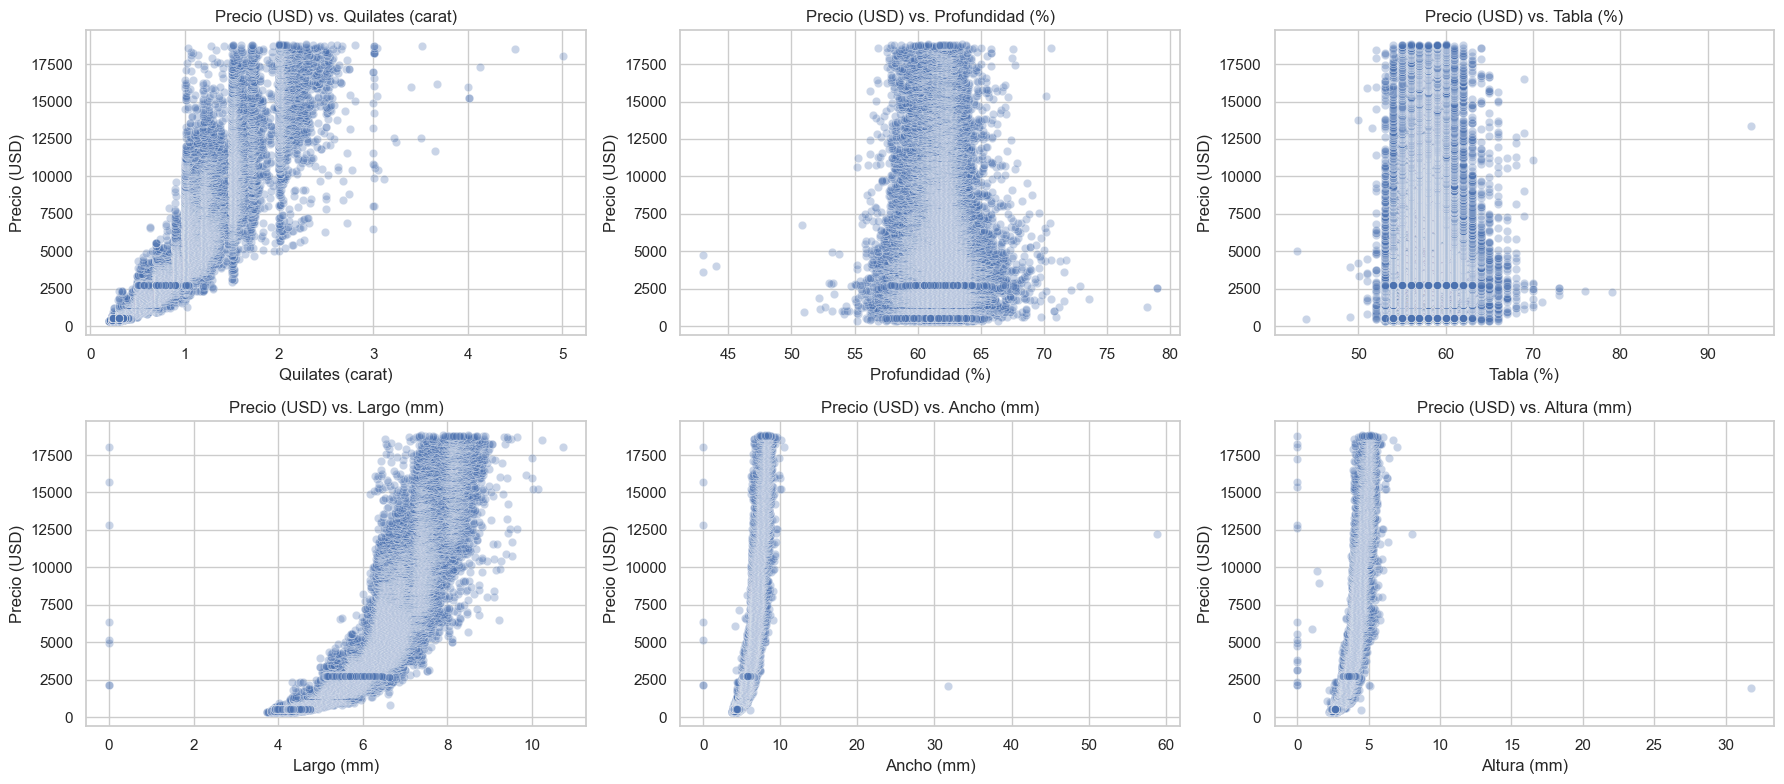

In [ ]:
num_cols = df.select_dtypes(include="number").columns.drop("price")
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.scatterplot(x=col, y="price", data=df, alpha=0.3, ax=ax)
    ax.set_title(f"Precio (USD) vs. {column_labels.get(col, col)}")
    ax.set_xlabel(column_labels.get(col, col))
    ax.set_ylabel(column_labels["price"])
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
plt.tight_layout()
plt.show()

De estos gráficos se puede apreciar lo siguiente:
- `carat` presenta una correlación positiva con respecto a `price`. Tiende a dispersarse mucho en los precios más altos y se llega a un pico de aumento. Este es un buen punto para escalar los datos de `price` para rectificar la curva y aclarar la varianza.
- `x`, `y` y `z` presentan correlaciones positivas afectadas por posibles outliers y valores extraños como el 0 en sus dimensiones. Idealmente se deberían descartar esos valores.
- La correlación de `table` y `depth`, como vimos anteriormente, es muy baja y no se nota ninguna tendencia (positiva o negativa) en los datos. Se podrían descartar estas columnas como predictores.

#### Diagramas de cajas

A continuación se muestra un diagrama de cajas de `price` contra `cut`, que es una variable categórica.

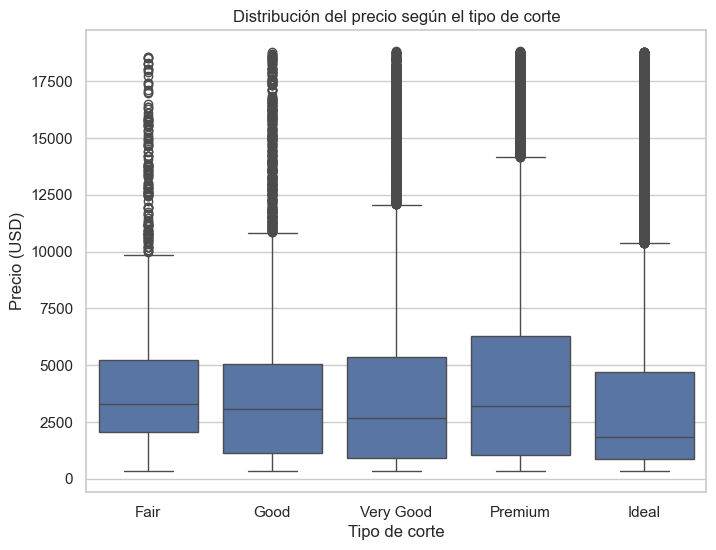

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="cut",
    y="price",
    data=df,
    order=cut_order,
)
plt.title("Distribución del precio según el tipo de corte")
plt.xlabel("Tipo de corte")
plt.ylabel(column_labels["price"])
plt.xticks(range(len(cut_order)), [cut_labels[int(cat)] for cat in cut_order])
plt.show()

El tipo de corte (la variable `cut`) influye muy poco en el precio y parece que solo introduce valores atípicos, ya que hay muchos diamantes con precios mayores de lo que se esperaría. No es el predictor más fuerte, pero puede que influya como valor categórico.

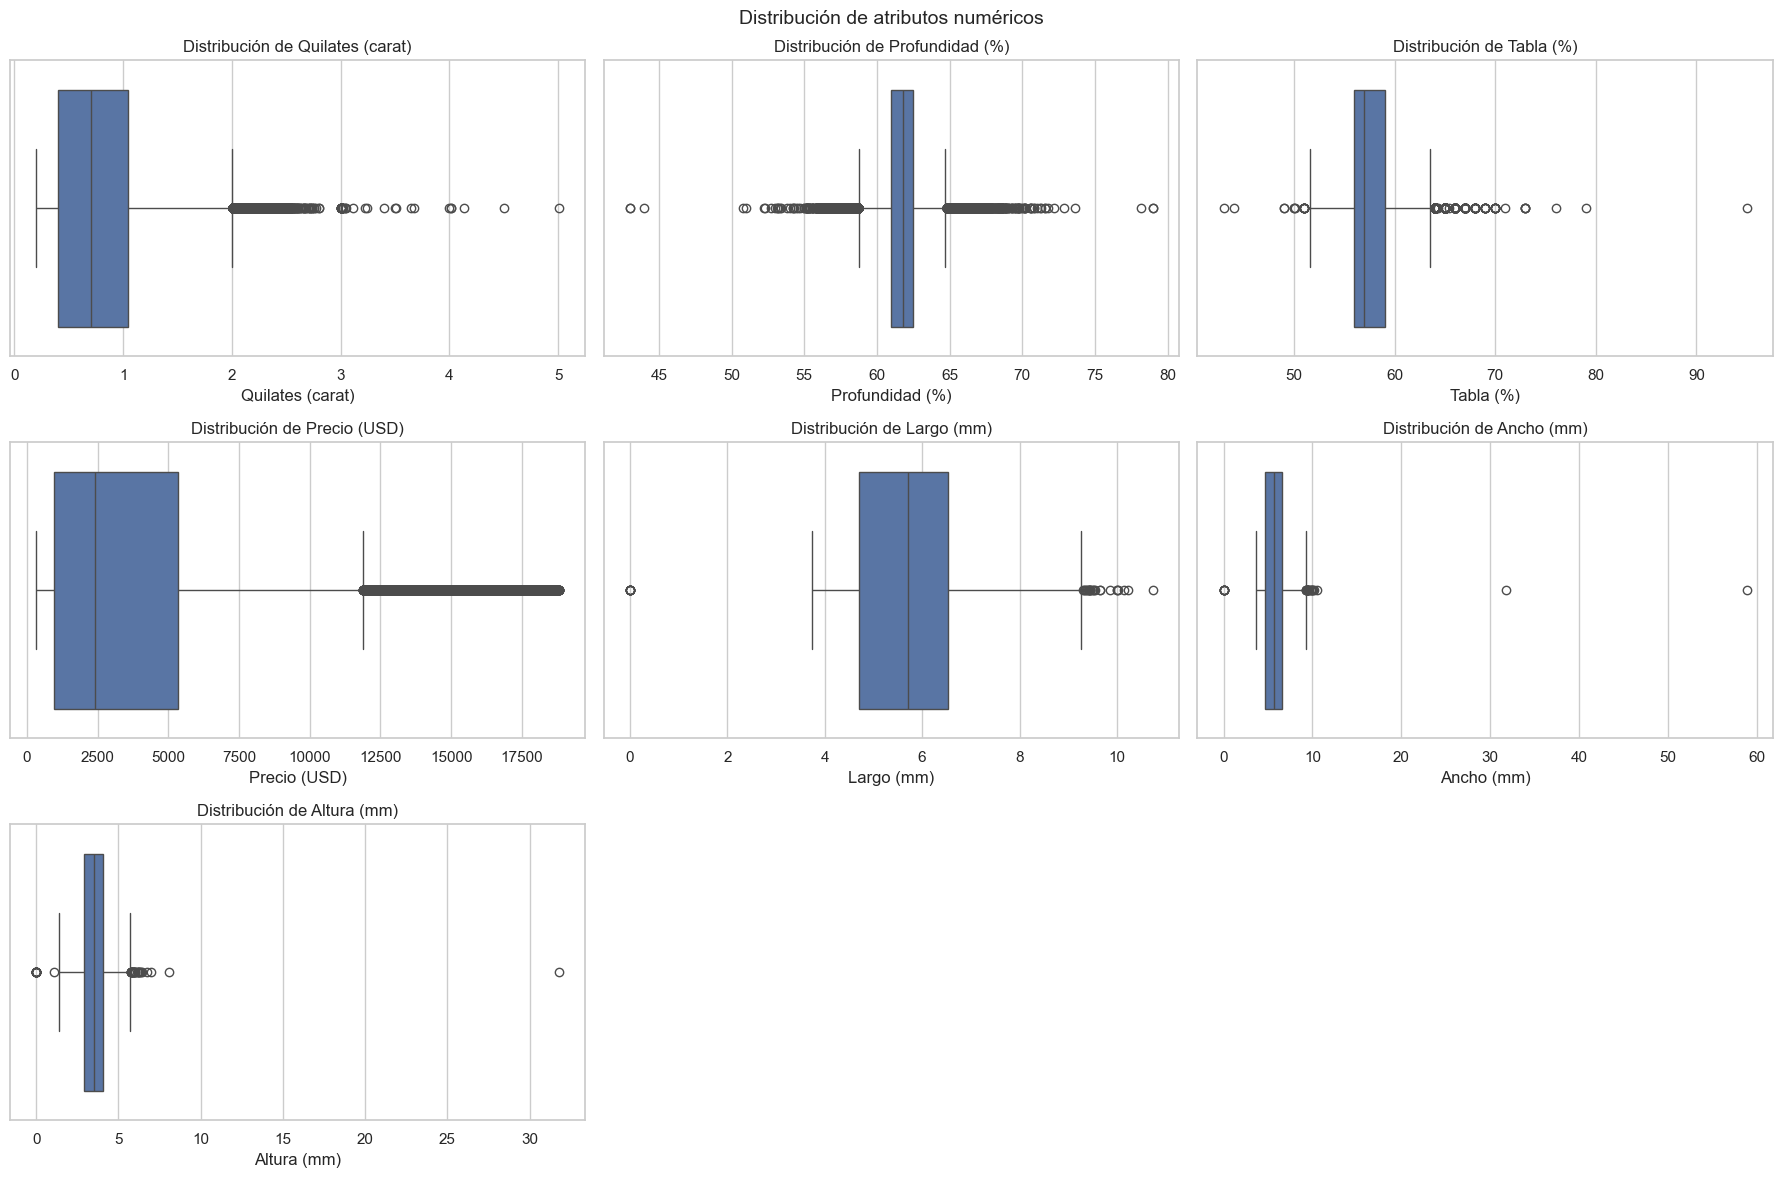

In [ ]:
num_cols = df.select_dtypes(include="number").columns
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.boxplot(x=col, data=df, ax=ax, orient="h")
    ax.set_title(f"Distribución de {column_labels.get(col, col)}")
    ax.set_xlabel(column_labels.get(col, col))
    ax.set_ylabel("")
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
fig.suptitle("Distribución de atributos numéricos", fontsize=14)
fig.tight_layout()
plt.show()

En estos diagramas de cajas puede apreciar que:
- `price` y `carat` presentan colas largas hacia la derecha. La mayor parte de los diamantes es barata y hay una cola de diamantes caros. Esto implica que muchos de los outliers por IQR no son errores, sino la realidad del mercado.
- `depth` y `table` están bastante concentrados cerca de 60, con algunos outliers a ambos lados, los cuales son posibles pero hay que tratar con cautela.
- `x`, `y` y `z` muestran valores imposibles (cercanos a 0) y extremos gigantes. Estos podrían ser posibles errores y deben filtrarse.

#### Histogramas

Finalmente revisamos el comportamiento de las variables mediante el uso de histogramas:

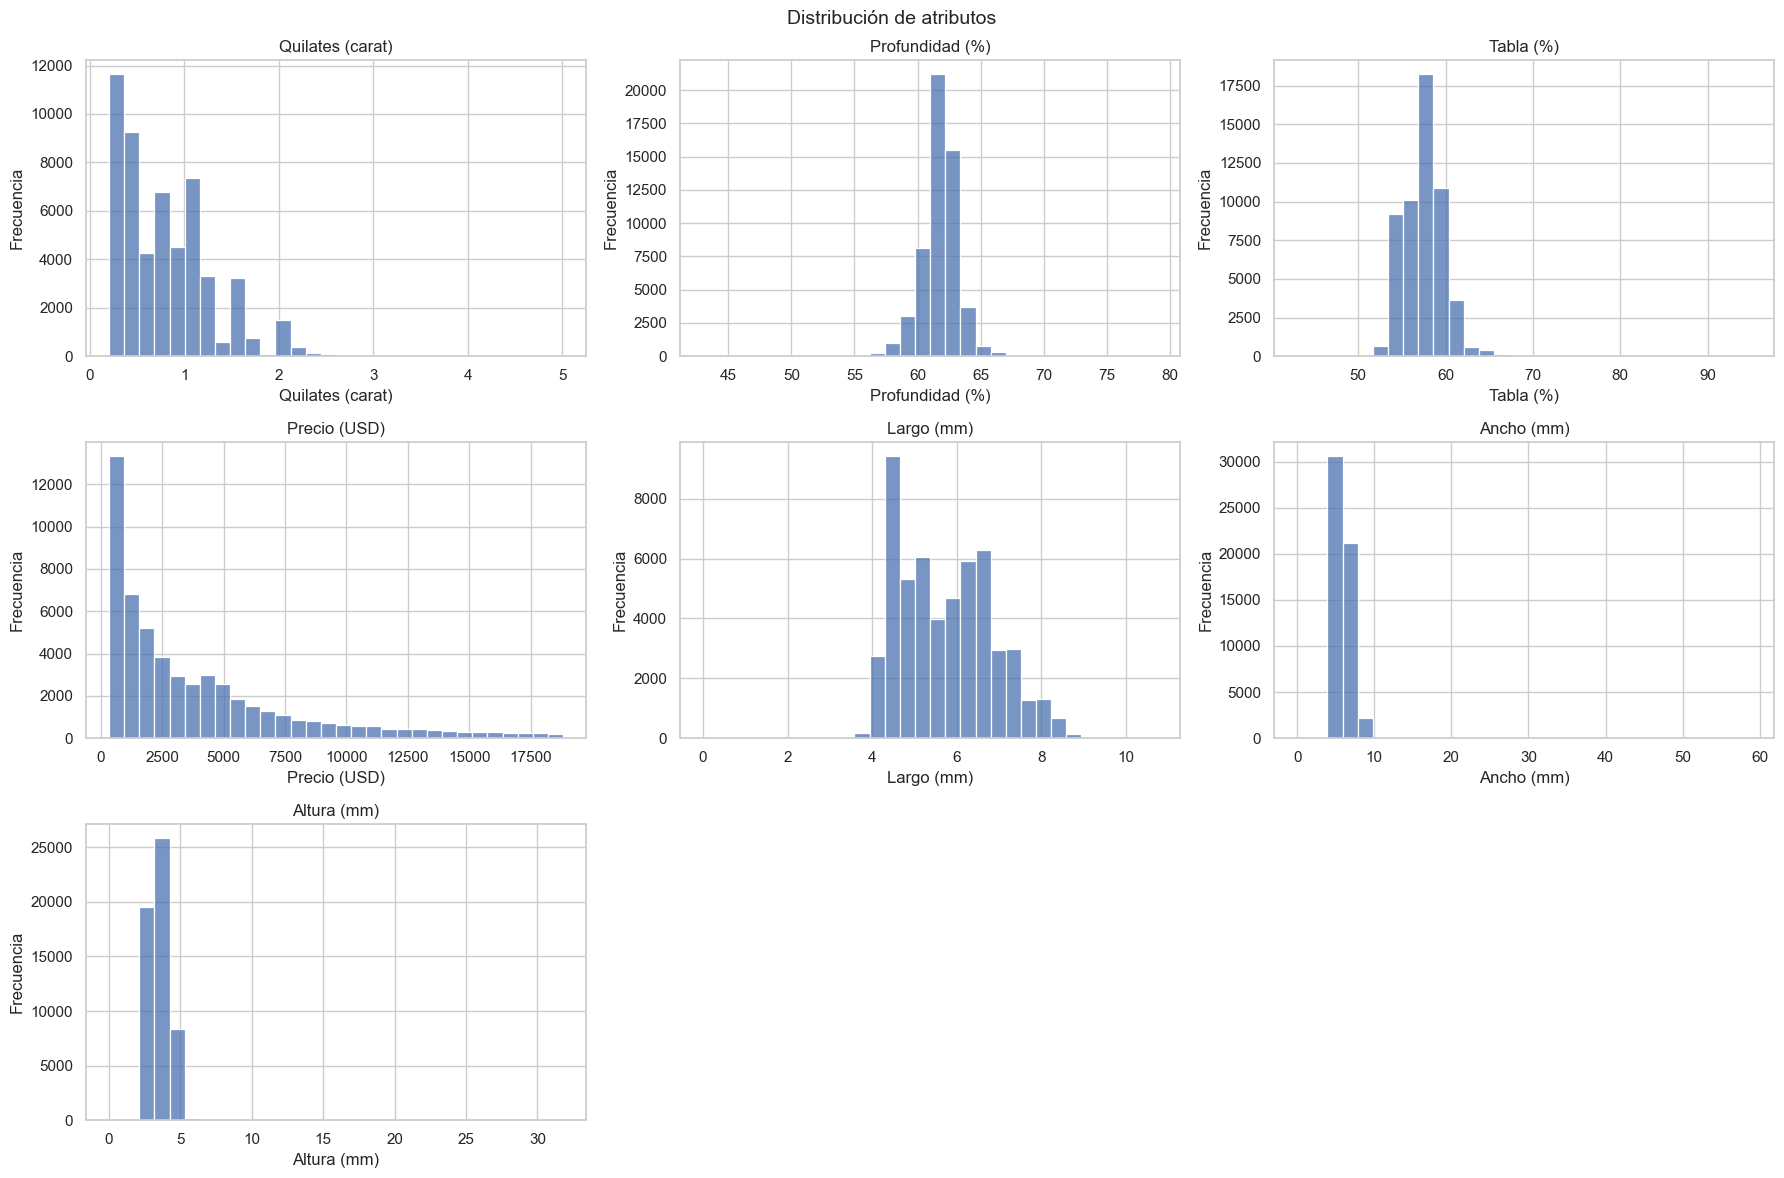

In [ ]:
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.histplot(x=df[col], bins=30, ax=ax, stat="count", color="#4C72B0", edgecolor="white")
    label = column_labels.get(col, col)
    ax.set_title(label)
    ax.set_xlabel(label)
    ax.set_ylabel("Frecuencia")
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
fig.suptitle("Distribución de atributos", fontsize=14)
fig.tight_layout()
plt.show()

Estos histogramas confirman nuestras observaciones anteriores.

### 2 (5 puntos)
- Se utilizará el modelo Train/Validation (70%) y Test (30%).
- Comente su decisión sobre los parámetros shuffle y random_state
- Separe los conjuntos de datos (70-30) (X_trainVal, X_test, y_trainVal, y_test )
- Muestre los primeros 5 registros de cada conjunto.

---

Para los parámetros mencionados se tomaron las siguientes decisiones:
- `shuffle`: el `DataFrame` no tiene una dependencia en el orden de sus datos y, como los datos más determinantes para la predicción tienden a valores más bajos, es beneficioso barajar las filas para evitar que el `train` o `test` solo contengan estos valores, es decir, para que haya una mejor distribución.
- `random_state`: debido a la naturaleza del trabajo práctico se desea tener reproducibilidad en las ejecuciones, especialmente porque se está trabajando en grupo. Debido a esto definir el valor del `random_state` es necesario para asegurar que la división sea la misma en varias ejecuciones, se escogió el número 42 por ser uno de los más comunes en ejemplos de regresión.

In [ ]:
x = df.drop("price", axis=1)
y = df["price"]

x_train_raw, x_test_raw, y_train_raw, y_test_raw = cast(
    tuple[DataFrame, DataFrame, Series, Series],
    train_test_split(x, y, test_size=0.30, random_state=42, shuffle=True),
)

In [ ]:
display(x_train_raw.head(5))
display(x_test_raw.head(5))
display(y_train_raw.head(5))
display(y_test_raw.head(5))

,carat,depth,table,x,y,z,cut
19497,1.21,61.3,57.0,6.92,6.87,4.23,4
31229,0.31,62.0,56.0,4.38,4.36,2.71,4
22311,1.21,62.4,57.0,6.75,6.83,4.24,4
278,0.81,62.6,55.0,5.92,5.96,3.72,4
6646,0.79,61.7,56.0,5.94,5.95,3.67,4


,carat,depth,table,x,y,z,cut
1388,0.24,62.1,56.0,3.97,4.00,2.47,4
50052,0.58,60.0,57.0,5.44,5.42,3.26,2
41645,0.40,62.1,55.0,4.76,4.74,2.95,4
42377,0.43,60.8,57.0,4.92,4.89,2.98,3
17244,1.55,62.3,55.0,7.44,7.37,4.61,4


19497     8131
31229      756
22311    10351
278       2795
6646      4092
Name: price, dtype: int64

1388      559
50052    2201
41645    1238
42377    1304
17244    6901
Name: price, dtype: int64

### 3 (10 puntos)
- Preprocese los atributos (Solo deje para más adelante escalar los datos).
- Debe comentar en celdas del texto el por qué seleccionó las técnicas utilizadas.

---

Primero mostremos la cantidad de datos que hay en cada conjunto antes de remover datos duplicados, outliers y datos inválidos.

In [ ]:
print(f"""
El conjunto de entrenamiento tiene {len(x_train_raw)} filas.
El conjunto de prueba tiene {len(x_test_raw)} filas.
""")


El conjunto de entrenamiento tiene 37758 filas.
El conjunto de prueba tiene 16182 filas.



#### Eliminación de datos duplicados

Al eliminar filas duplicadas se mejora la integridad del modelo y se evita sobrerepresentar ciertas observaciones, esto puede servir en el caso de diamantes ya que la predicción puede ser afectada por el precio de mercado especialmente en los valores de `carat` bajos.

In [ ]:
x_train_no_dups = x_train_raw.drop_duplicates()
x_test_no_dups = x_test_raw.drop_duplicates()

y_train_no_dups = y_train_raw.loc[x_train_no_dups.index]
y_test_no_dups = y_test_raw.loc[x_test_no_dups.index]

#### Remoción de outliers y datos inválidos

Estos datos como $x,y,z = 0$ o dimensiones no realistas pueden afectar al modelo e introducir ruido, por lo que se decidió filtrarlos. También se decidió filtrar los valores fuera del rango intercuartílico (IQR) para las dimensiones `x`, `y` y `z`, ya que estos pueden ser _outliers_.

In [ ]:
xyz_cols = ["x", "y", "z"]
xyz_quartiles = x_train_no_dups[xyz_cols].quantile([0.25, 0.75])
xyz_iqr = xyz_quartiles.loc[0.75] - xyz_quartiles.loc[0.25]
xyz_bounds = pd.DataFrame(
    {
        "lower": xyz_quartiles.loc[0.25] - 1.5 * xyz_iqr,
        "upper": xyz_quartiles.loc[0.75] + 1.5 * xyz_iqr,
    }
)


def quality_filter(df: DataFrame, bounds: DataFrame) -> Series:
    base_mask = (
        (df["carat"] > 0)
        & (df["x"] > 0)
        & (df["y"] > 0)
        & (df["z"] > 0)
        & (df["depth"].between(40, 80))
        & (df["table"].between(40, 80))
    )
    xyz_mask = (df[xyz_cols].ge(bounds["lower"]) & df[xyz_cols].le(bounds["upper"])).all(axis=1)
    return base_mask & xyz_mask


train_quality_mask = quality_filter(x_train_no_dups, xyz_bounds)
test_quality_mask = quality_filter(x_test_no_dups, xyz_bounds)

x_train_filtered = x_train_no_dups.loc[train_quality_mask]
y_train_filtered = y_train_no_dups.loc[train_quality_mask]
x_test_filtered = x_test_no_dups.loc[test_quality_mask]
y_test_filtered = y_test_no_dups.loc[test_quality_mask]

La función `quality_filter` encapsula todos los criterios vigentes (valores mínimos razonables, rangos válidos de `depth` y `table`, además de los límites basados en el IQR de `x`, `y` y `z`). Los umbrales del IQR se calculan únicamente con el conjunto de entrenamiento para evitar fugas de información hacia el conjunto de prueba; posteriormente se reutilizan para filtrar ambos subconjuntos de manera consistente.

Con el código a continuación podemos observar la cantidad de datos que hay en cada conjunto después de remover datos duplicados, outliers y datos inválidos.

In [ ]:
print(f"""
El conjunto de entrenamiento tiene {len(x_train_filtered)} filas.
El conjunto de prueba tiene {len(x_test_filtered)} filas.
""")


El conjunto de entrenamiento tiene 36290 filas.
El conjunto de prueba tiene 15864 filas.



#### Gráficos después de la limpieza

##### Diagramas de dispersión

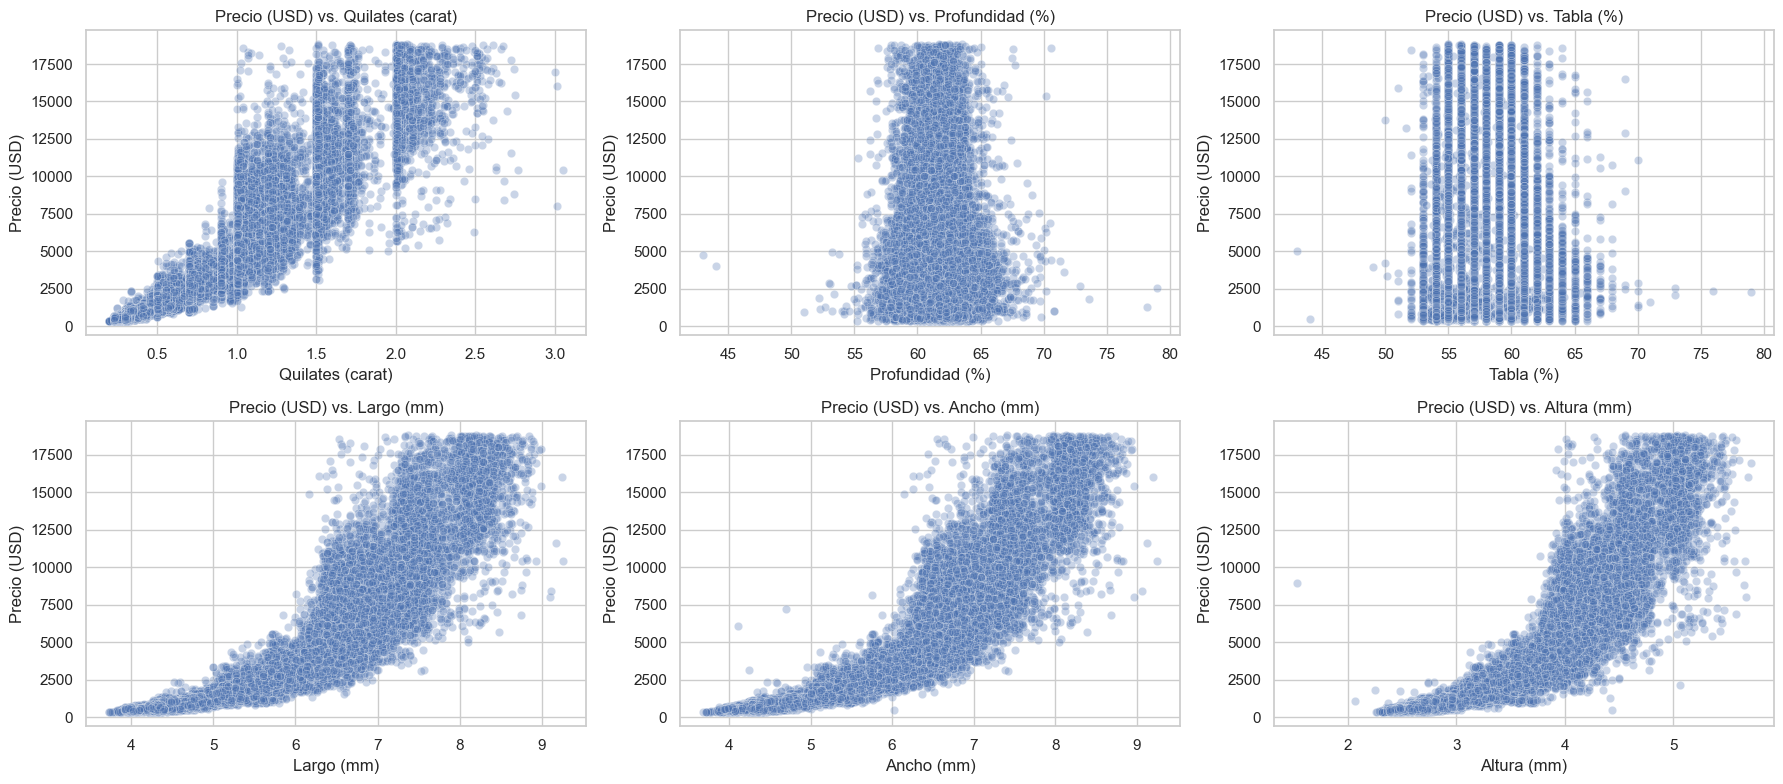

In [ ]:
train_df = x_train_filtered.copy()
train_df["price"] = y_train_filtered

num_cols = x_train_filtered.select_dtypes(include="number").columns
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.scatterplot(x=col, y="price", data=train_df, alpha=0.3, ax=ax)
    ax.set_title(f"{column_labels['price']} vs. {column_labels.get(col, col)}")
    ax.set_xlabel(column_labels.get(col, col))
    ax.set_ylabel(column_labels["price"])
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
plt.tight_layout()
plt.show()

##### Diagramas de cajas

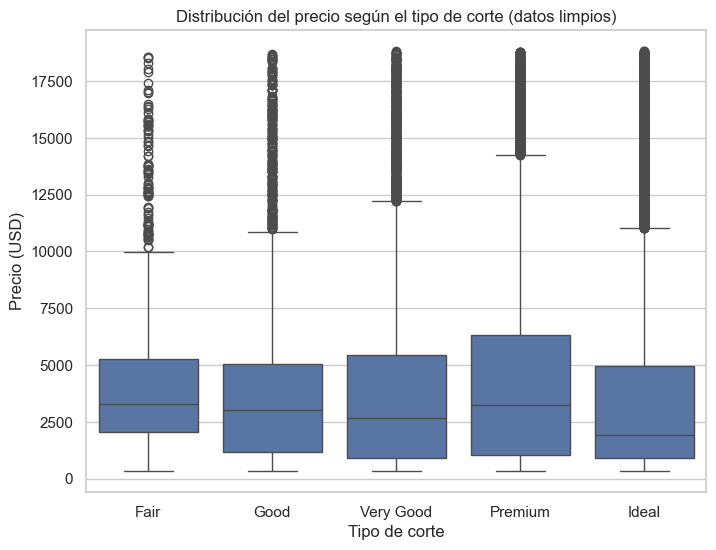

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="cut",
    y="price",
    data=train_df,
    order=cut_order,
)
plt.title("Distribución del precio según el tipo de corte (datos limpios)")
plt.xlabel("Tipo de corte")
plt.ylabel(column_labels["price"])
plt.xticks(range(len(cut_order)), [cut_labels[int(cat)] for cat in cut_order])
plt.show()

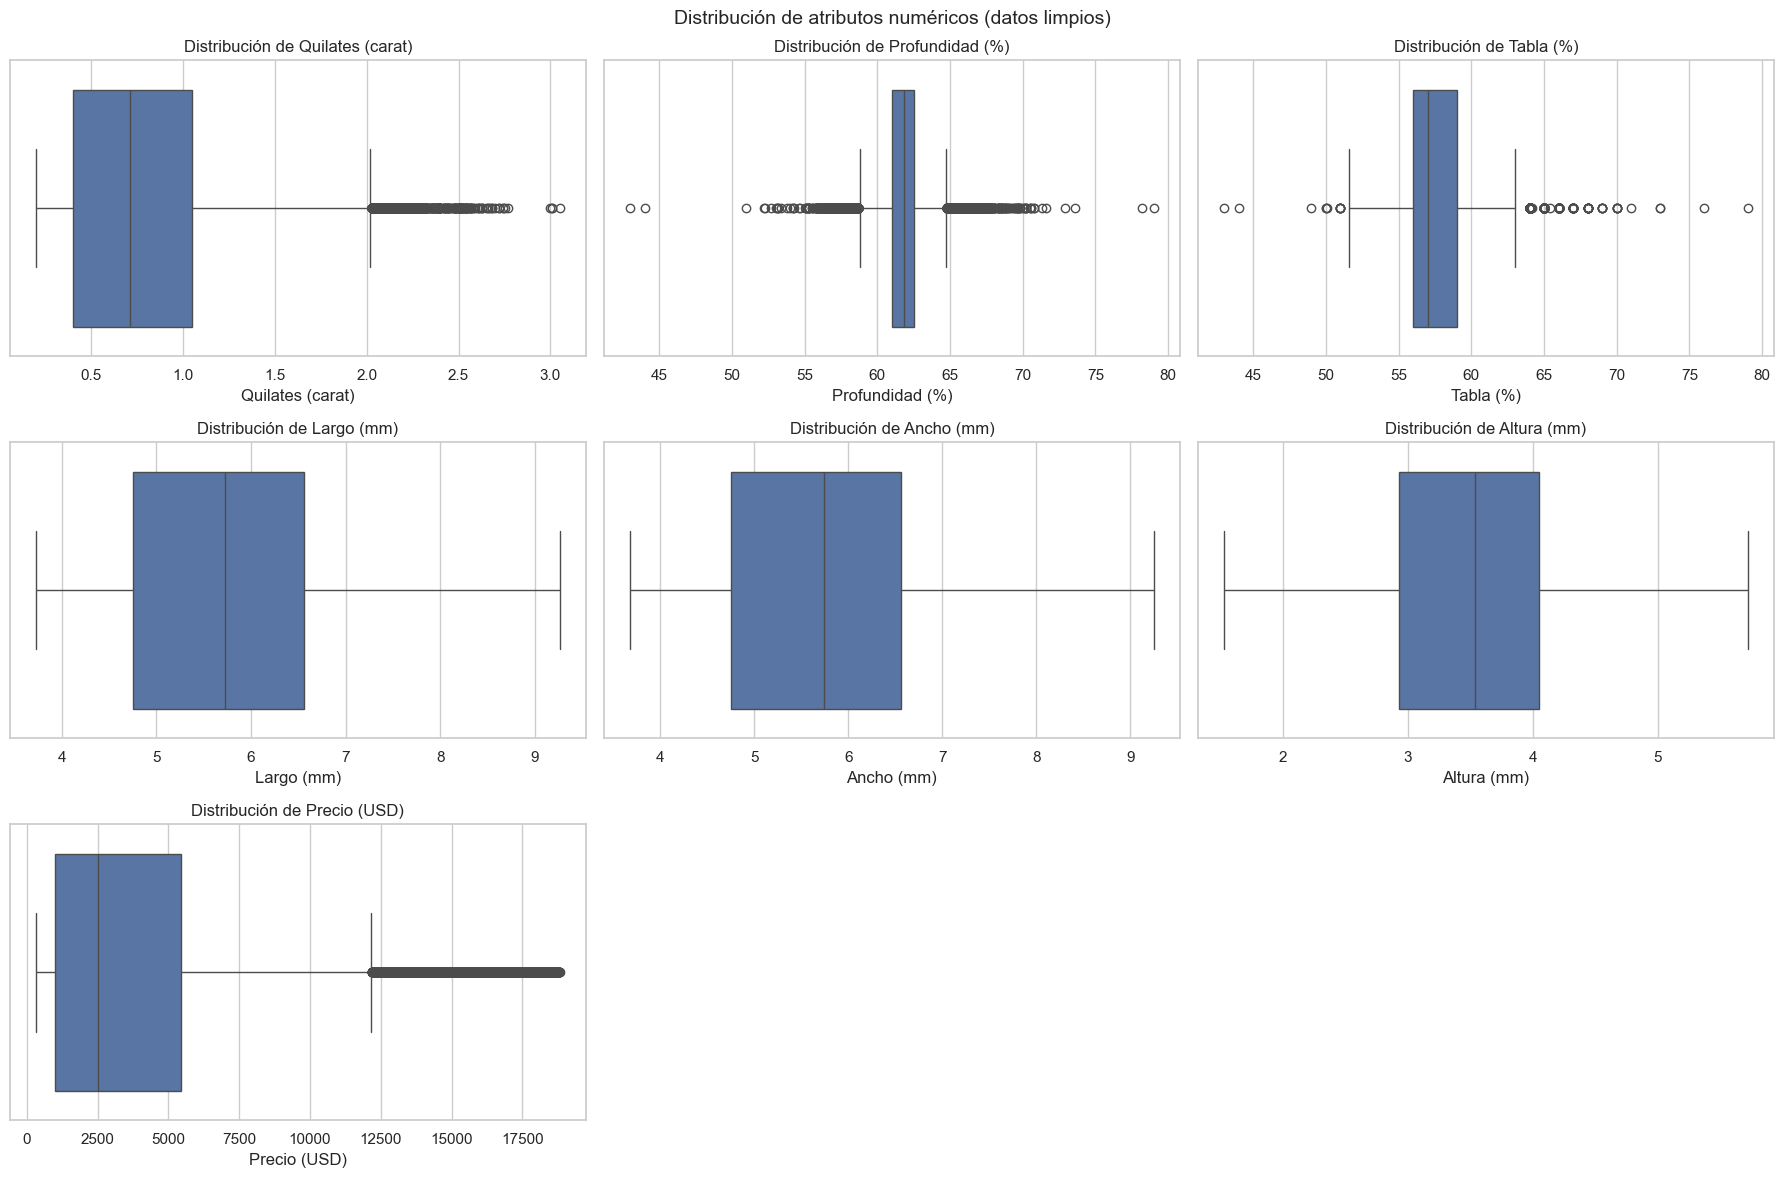

In [ ]:
num_cols = train_df.select_dtypes(include="number").columns
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.boxplot(x=col, data=train_df, ax=ax, orient="h")
    ax.set_title(f"Distribución de {column_labels.get(col, col)}")
    ax.set_xlabel(column_labels.get(col, col))
    ax.set_ylabel("")
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
fig.suptitle("Distribución de atributos numéricos (datos limpios)", fontsize=14)
fig.tight_layout()
plt.show()

##### Histogramas

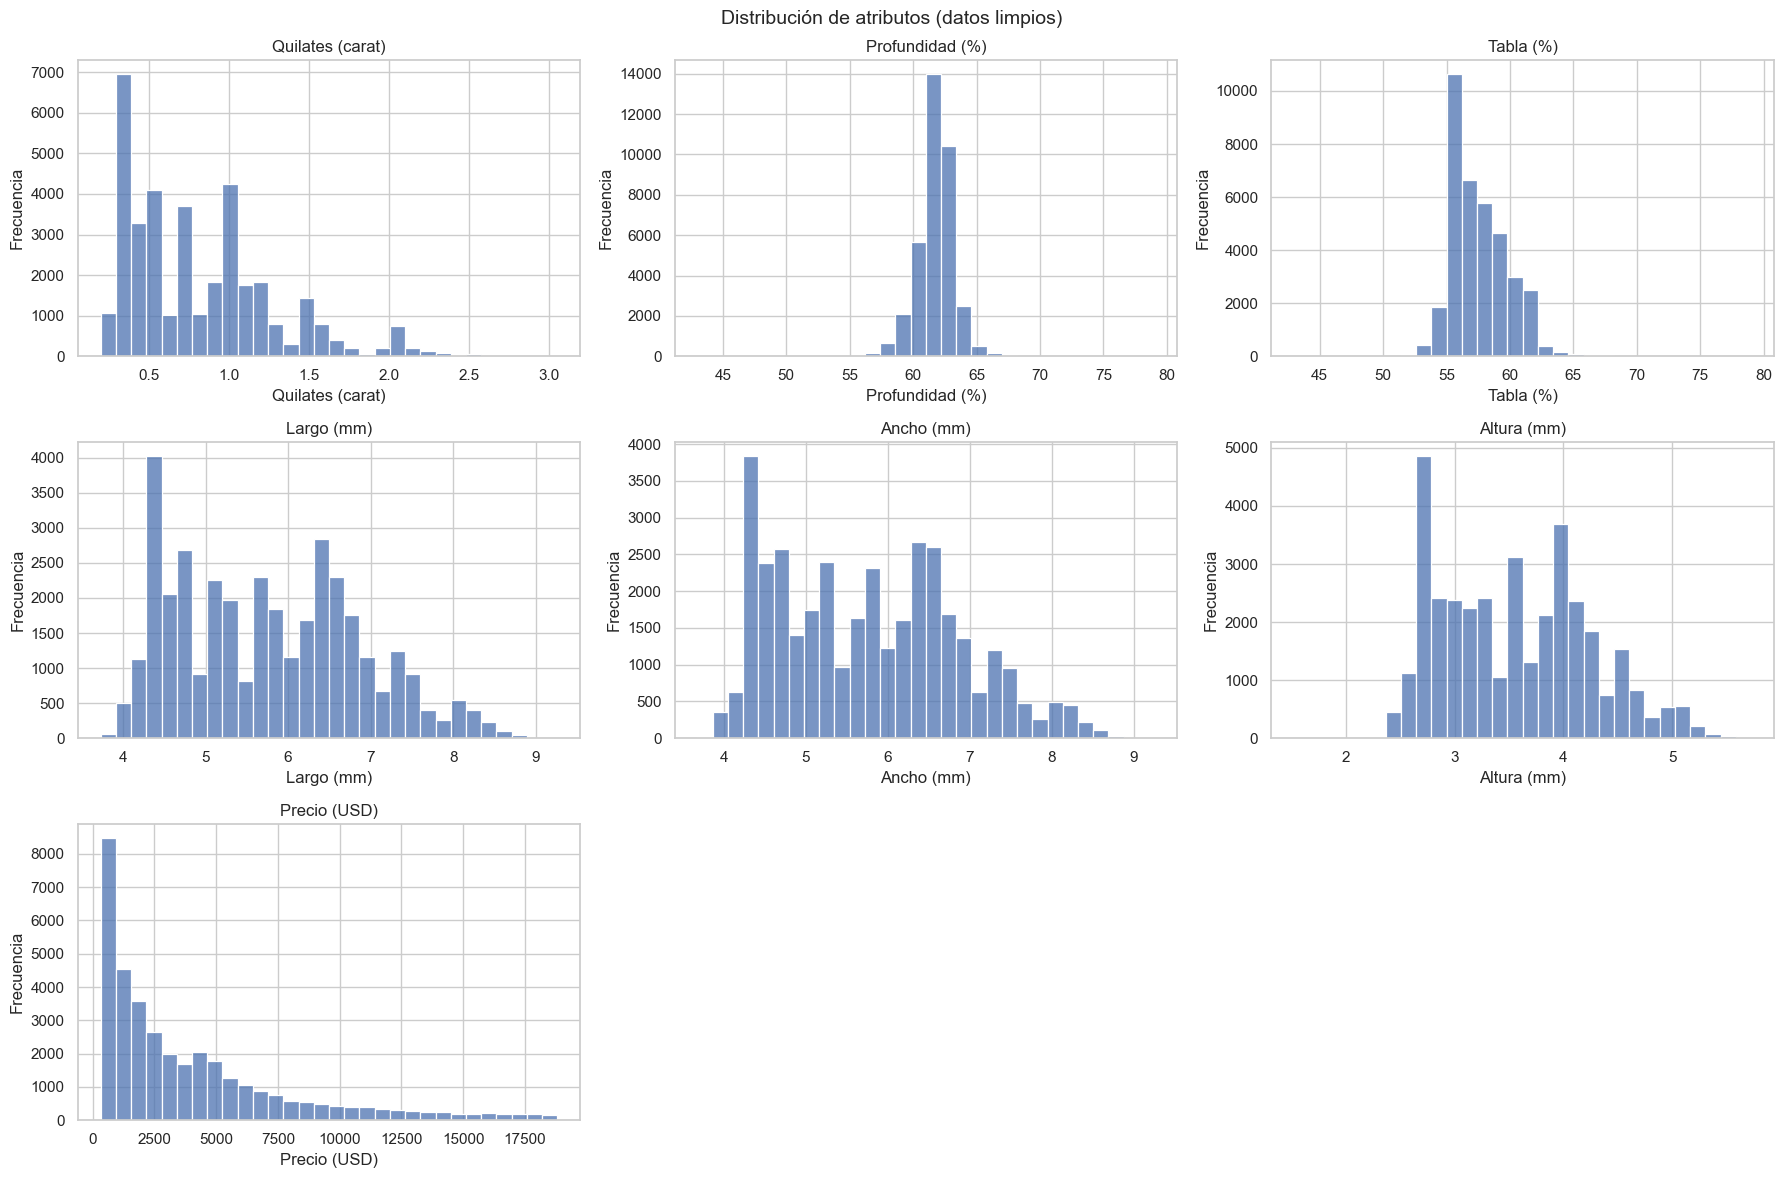

In [ ]:
num_cols = train_df.select_dtypes(include="number").columns
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.histplot(x=train_df[col], bins=30, ax=ax, stat="count", color="#4C72B0", edgecolor="white")
    label = column_labels.get(col, col)
    ax.set_title(label)
    ax.set_xlabel(label)
    ax.set_ylabel("Frecuencia")
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
fig.suptitle("Distribución de atributos (datos limpios)", fontsize=14)
fig.tight_layout()
plt.show()

### 4 (5 puntos)
- Realice selección de atributos.
- Debe utilizar al menos una técnica para justificar su decisión (De entre los métodos: Filter, Wrapper, Embedded).
- Comente sus conclusiones.

---

La técnica que deseamos utilizar para la selección de atributos es la de _Filter_, ya que es una técnica sencilla y con el análisis previo pudimos observar que varios atributos no aportan información significativa para la predicción del precio.

Con el código a continuación podemos observar la correlación entre los diferentes atributos del `DataFrame` y `price`. Se debe tomar en consideración que esta es la misma correlación que se mostró anteriormente.

In [ ]:
corr_with_price = train_df.corr()["price"].drop("price")

correlation_table = (
    corr_with_price.to_frame(name="correlación")
    .assign(correlación_abs=lambda df_: df_["correlación"].abs())
    .sort_values("correlación_abs", ascending=False)
)

display(correlation_table)

,correlación,correlación_abs
carat,0.922755,0.922755
y,0.887984,0.887984
x,0.886648,0.886648
z,0.881958,0.881958
table,0.108540,0.108540
cut,-0.039369,0.039369
depth,-0.003236,0.003236


Esta tabla muestra que los atributos `carat`, `x`, `y` y `z` tienen una correlación significativa con `price`, pero a como vimos anteriormente, `x`, `y` y `z` están altamente correlacionados entre sí y con `carat`. Por lo tanto, se decidió conservar solo `carat` y eliminar `x`, `y` y `z`.

Para no eliminar más atributos, se decidió conservar `cut` y `table`, ya que aunque su correlación es baja pueden aportar información adicional al modelo. Se decidió conservar específicamente `cut` y `table` porque son los que más correlación tienen con `price` de los atributos restantes. Esto nos da como resultado el Top #3 de atributos más correlacionados con `price`.

In [ ]:
x_train_selected = x_train_filtered.drop(columns=["x", "y", "z", "depth"])
x_test_selected = x_test_filtered.drop(columns=["x", "y", "z", "depth"])

### 1.5 (5 puntos)
- Escale los datos.
- Comente qué técnica utilizó y por qué.
- Guarde el archivo ya pre-procesado con el nombre: "'diamondsPROCESADO"

**Nota:** No olvide cómo manejará el "bias" (o agregar columna de unos, o si la implementación de los algoritmos que utilizará permiten indicarle que lo agregue).

---

Con el código a continuación se realiza el escalamiento de los datos.

In [ ]:
numeric_cols = ["carat", "table"]
categorical_cols = ["cut"]

log1p_numeric = FunctionTransformer(lambda data: data.assign(carat=np.log1p(data["carat"])), validate=False)
numeric_pipeline = Pipeline(steps=[("log1p", log1p_numeric), ("scaler", MinMaxScaler())])

categorical_pipeline = Pipeline(
    steps=[("onehot", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False))]
)

diamonds_preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, numeric_cols),
        ("categorical", categorical_pipeline, categorical_cols),
    ],
    verbose_feature_names_out=False,
)

x_train = cast(DataFrame, diamonds_preprocessor.fit_transform(x_train_selected))
x_test = cast(DataFrame, diamonds_preprocessor.transform(x_test_selected))

y_train = np.log1p(y_train_filtered)
y_test = np.log1p(y_test_filtered)

diamonds_train_processed = x_train.assign(price_log=y_train, price=y_train_filtered, split="train")
diamonds_test_processed = x_test.assign(price_log=y_test, price=y_test_filtered, split="test")
diamonds_processed = (
    pd.concat([diamonds_train_processed, diamonds_test_processed], axis=0).sort_index().reset_index(drop=True)
)
diamonds_processed.to_csv("./data/diamondsPROCESADO.csv", index=False)

Estas decisiones de preprocesamiento buscan mejorar la estabilidad numérica y evitar sesgos en los modelos posteriores:
- Transformar `carat` y `price` con `log1p` mitiga la fuerte asimetría de ambas distribuciones para que los algoritmos lineales se desempeñen mejor.
- Escalar las variables numéricas con `MinMaxScaler` evita que diferencias de magnitud dominen el ajuste; y codificar `cut` con _one-hot encoding_ elimina la falsa noción de orden inherente a su codificación original.
- Al guardar el conjunto resultante, con etiquetas que recuerdan su partición de origen, garantizamos que cualquier experimento futuro parta de exactamente del mismo punto.

### 1.6 (15 puntos)
Presente e implemente un diseño experimental que incluya:
- Dos algoritmos diferentes:
    - Uno será la regresión lineal de mínimos cuadrados sin regularización (OLSR).
    - Usted elegirá un método más, que no sea de los vistos en clase. Si tiene dudas de si puede o no usar algún método, puede consultar al profesor. Para el segundo método deberá elegir al menos un hiperparámetro.
    - Como el OLSR no tiene hiperparámetros, use todo el train/validation para entrenar. Para el otro método, debe usar ten-cross-validation para seleccionar al menos un hiperparámetro.
    - Debe registrar las métricas RMSE y R2. Usted decide cuál de estas dos métricas usa para seleccionar la mejor configuración (Justifique su selección).

**Nota:** Para el algoritmos seleccionado (no el OLSR) explique los parámetros que recibe según la biblioteca utilizada.

---

#### 1.6.1 OLSR (LinearRegression)

A continuación se muestra la implementación del modelo de regresión lineal ordinaria (OLSR) utilizando la clase `LinearRegression` de la biblioteca `sklearn`. Este modelo no tiene hiperparámetros que ajustar, por lo que se entrena directamente con todo el conjunto de entrenamiento y validación.

In [ ]:
olsr_model = LinearRegression()
olsr_model.fit(x_train, y_train)
olsr_y_pred = olsr_model.predict(x_test)

olsr_r2: float = r2_score(np.expm1(y_test), np.expm1(olsr_y_pred))
olsr_rmse: float = root_mean_squared_error(np.expm1(y_test), np.expm1(olsr_y_pred))

print(f"R²: {olsr_r2:.4f}")
print(f"RMSE: {olsr_rmse:.4f}")

R²: 0.5716
RMSE: 2586.8687


#### 1.6.2 Decision Tree Regressor (DTR)

Como segundo método se eligió el modelo de árbol de decisión para regresión (`DecisionTreeRegressor`). Este modelo es capaz de capturar relaciones no lineales entre las variables predictoras y la variable objetivo, lo que puede ser beneficioso dado que la relación entre los atributos y el precio del diamante no es estrictamente lineal.

A continuación se muestra la implementación del modelo de árbol de decisión para regresión utilizando la clase `DecisionTreeRegressor` de la biblioteca `sklearn`. En este caso, se utiliza validación cruzada con 10 particiones (10-fold cross-validation) para seleccionar los mejores hiperparámetros basados en la métrica RMSE (Root Mean Squared Error).

Se eligió utilizar RMSE como métrica de selección de hiperparámetros porque penaliza más los errores grandes en la predicción, lo cual es importante en este contexto donde los precios de los diamantes pueden variar significativamente.

Los hiperparámetros que se ajustarán mediante validación cruzada son:
- `max_depth`: profundidad máxima del árbol (controla complejidad/_overfitting_).
- `min_samples_leaf`: mínimo de muestras en una hoja (suaviza predicciones).
- `min_samples_split`: mínimo para dividir un nodo.

In [ ]:
tree = DecisionTreeRegressor(random_state=42)

param_grid = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_leaf": [1, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

gs = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # Negativo para maximizar
    cv=cv,
    n_jobs=-1,
    refit=True,  # Se reentrena con los mejores hiperparámetros
)
gs.fit(x_train, y_train)

print("Mejores hiperparámetros (CV por RMSE):", gs.best_params_)
print(f"RMSE medio CV (neg): {gs.best_score_:.4f}")

tree_y_pred = gs.predict(x_test)

tree_rmse = root_mean_squared_error(np.expm1(y_test), np.expm1(tree_y_pred))
tree_r2 = r2_score(np.expm1(y_test), np.expm1(tree_y_pred))

print(f"R²: {tree_r2:.4f}")
print(f"RMSE: {tree_rmse:.4f}")

Mejores hiperparámetros (CV por RMSE): {'max_depth': 9, 'min_samples_leaf': 20, 'min_samples_split': 2}
RMSE medio CV (neg): -0.2413
R²: 0.8764
RMSE: 1389.5620


### 1.7 (5 puntos)
- Por medio de una tabla u otro método idóneo que Usted determine, resuma todos los resultados obtenidos (o la mayoría).
- Grafique comparativamente los valores del real versus el predicho (test), de cada uno de los métodos utilizados.
- Qué conclusiones finales saca sobre los métodos usados como predictores.

---

Para sintetizar los resultados principales, a continuación se construye una tabla con las métricas obtenidas por cada modelo y un breve resumen que facilita comparar su desempeño.

In [ ]:
results_summary = (
    pd.DataFrame(
        {
            "Modelo": ["Regresión lineal (OLSR)", "Árbol de decisión (DTR)"],
            "RMSE": [olsr_rmse, tree_rmse],
            "R²": [olsr_r2, tree_r2],
        }
    )
    .set_index("Modelo")
    .sort_values("RMSE")
)

best_rmse_model = results_summary["RMSE"].idxmin()
best_r2_model = results_summary["R²"].idxmax()

display(results_summary.style.format({"RMSE": "{:.2f}", "R²": "{:.3f}"}))

,RMSE,R²
Modelo,,
Árbol de decisión (DTR),1389.56,0.876
Regresión lineal (OLSR),2586.87,0.572


Las conclusiones clave son las siguientes:
- El modelo con menor RMSE es **Árbol de decisión (DTR)**, por lo que reduce en mayor medida los errores grandes.
- El mayor R² corresponde a **Árbol de decisión (DTR)**, lo que indica que explica la mayor proporción de la variabilidad del precio.

Debido a esto el modelo más recomendado para este conjunto de datos es el **Árbol de decisión (DTR)**, ya que maneja mejor la complejidad inherente a la predicción del precio de los diamantes en comparación con la **Regresión lineal (OLSR)**.

A continuación se presentan dos gráficos (uno por modelo) con los valores reales del conjunto de prueba (sin transformaciones) y las predicciones obtenidas sobre esos mismos diamantes.

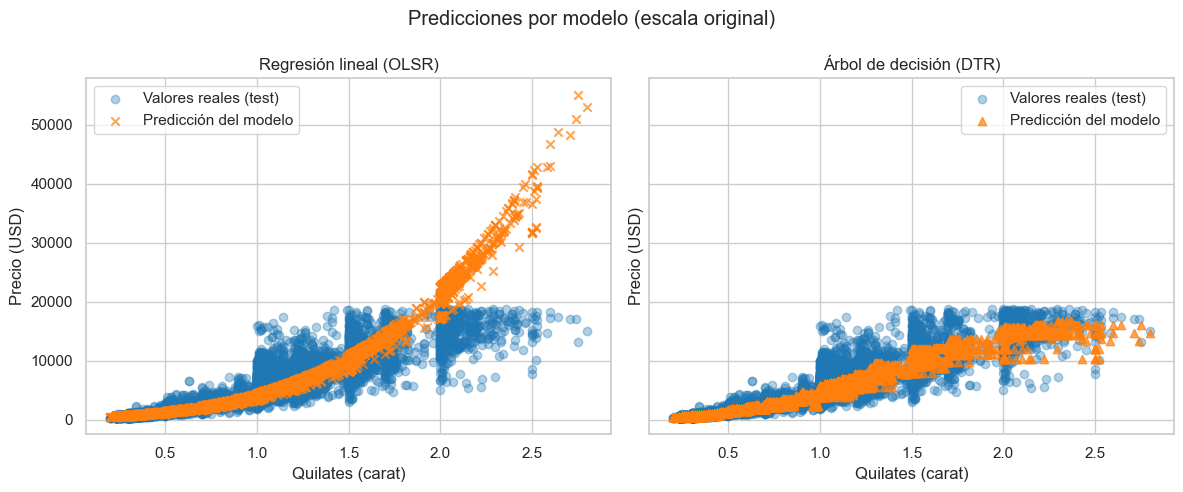

In [ ]:
y_test_real = np.expm1(y_test)
olsr_pred_real = np.expm1(olsr_y_pred)
tree_pred_real = np.expm1(tree_y_pred)
carat_test_real = x_test_selected["carat"].to_numpy()

fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharex=True, sharey=True)

plots = [
    ("Regresión lineal (OLSR)", olsr_pred_real, "tab:orange", "x"),
    ("Árbol de decisión (DTR)", tree_pred_real, "tab:orange", "^"),
]

for ax, (title, preds, color, marker) in zip(axes, plots):
    ax.scatter(carat_test_real, y_test_real, alpha=0.35, label="Valores reales (test)", color="tab:blue")
    ax.scatter(
        carat_test_real,
        preds,
        alpha=0.7,
        label="Predicción del modelo",
        color=color,
        marker=marker,
    )
    ax.set(title=title, xlabel=column_labels["carat"], ylabel=column_labels["price"])
    ax.legend()

fig.suptitle("Predicciones por modelo (escala original)")
plt.tight_layout()
plt.show()

Con estos gráficos se puede observar que el modelo de árbol de decisión captura mejor la variabilidad en los precios, especialmente en los rangos más altos, en los que la regresión lineal tiene dificultades para ajustarse adecuadamente (la **Regresión lineal (OLSR)** despega luego de los 2 quilates). Si bien el árbol tiende a subestimar ligeramente los diamantes más pesados, sus errores siguen siendo mucho menores que las sobreestimaciones pronunciadas del modelo lineal.

___

# Parte 2 - Clasificación (50 puntos)

### Considere lo siguiente:
1. Conjunto de datos: **cardio.csv**
2. Algunos detalles del conjunto de datos los puede ver en: <https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset>.
3. El atributo a predecir es: **cardio**.
4. Proponga al menos dos algoritmos a utilizar
5. Métricas:
    1. Accuracy
    2. Ustedes propongan una más.
6. Debe presentar en este cuaderno:
    1. Pre-procesamiento de los datos, explicando las decisiones en cada caso.
    2. Para cada uno de los algoritmos seleccionados:
        1. Explicación del algoritmo.
        2. Explicación de la implementación seleccionada y de sus parámetros (según la biblioteca).
    4. Explicación del diseño experimental por ejecutar. Recuerde que si el algoritmo requiere seleccionar hiperparámetros, hay que dividir en tres conjuntos de datos: Training, Validation, Testing (60%, 20%, 20%). Se le recomienda confirmar con el profesor cuántos y cuáles hiperparámetros validar.
    5. Programación del diseño experimental.
    6. Tablas de resultados, gráficos y conclusiones de los resultados, recomendando a su contratante cuál algoritmo utilizar, con qué configuración y por qué lo recomienda.

---

In [24]:
df = pd.read_csv("./data/cardio.csv", sep=';', encoding='utf-8')

df = df.drop('id', axis=1)

df.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,23393,1,155,62.0,120,80,1,1,0,0,1,0
5,21143,1,164,61.0,100,70,1,1,0,0,1,0
6,18085,1,162,72.0,100,70,1,1,0,0,1,0
7,22547,1,161,93.0,140,90,2,1,0,0,1,1
8,21250,1,157,68.0,110,80,1,1,0,0,1,0
9,22446,1,158,65.0,140,90,3,1,0,0,1,1


In [25]:
# Gender
df["gender"] = df["gender"].astype("category")
gender_map = dict(zip(df["gender"].cat.categories, ["Female", "Male"]))

# Cholesterol
df["cholesterol"] = df["cholesterol"].astype("category")
cholesterol_map = dict(zip(df["cholesterol"].cat.categories, ["normal", "above normal", "well above normal"]))

# Glucose
df["gluc"] = df["gluc"].astype("category")
gluc_map = dict(zip(df["gluc"].cat.categories, ["normal", "above normal", "well above normal"]))

# Smoke
df["smoke"] = df["smoke"].astype("category")
smoke_map = dict(zip(df["smoke"].cat.categories, ["Non-smoker", "Smoker"]))

# Alcohol
df["alco"] = df["alco"].astype("category")
alco_map = dict(zip(df["alco"].cat.categories, ["Non-alcoholic", "Alcohol Drinker"]))

# Active
df["active"] = df["active"].astype("category")
active_map = dict(zip(df["active"].cat.categories, ["Non-active", "Active"]))

# Cardio
df["cardio"] = df["cardio"].astype("category")
cardio_map = dict(zip(df["cardio"].cat.categories, ["Absence of cardiovascular disease", "Presence of cardiovascular disease"]))

# Combine all maps into one dictionary
value_label_map = {
    "gender": gender_map,
    "cholesterol": cholesterol_map,
    "gluc": gluc_map,
    "smoke": smoke_map,
    "alco": alco_map,
    "active": active_map,
    "cardio": cardio_map
}

print(value_label_map)

{'gender': {1: 'Female', 2: 'Male'}, 'cholesterol': {1: 'normal', 2: 'above normal', 3: 'well above normal'}, 'gluc': {1: 'normal', 2: 'above normal', 3: 'well above normal'}, 'smoke': {0: 'Non-smoker', 1: 'Smoker'}, 'alco': {0: 'Non-alcoholic', 1: 'Alcohol Drinker'}, 'active': {0: 'Non-active', 1: 'Active'}, 'cardio': {0: 'Absence of cardiovascular disease', 1: 'Presence of cardiovascular disease'}}


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69301 entries, 0 to 69300
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          69301 non-null  int64   
 1   gender       69301 non-null  category
 2   height       69301 non-null  int64   
 3   weight       69301 non-null  float64 
 4   ap_hi        69301 non-null  int64   
 5   ap_lo        69301 non-null  int64   
 6   cholesterol  69301 non-null  category
 7   gluc         69301 non-null  category
 8   smoke        69301 non-null  category
 9   alco         69301 non-null  category
 10  active       69301 non-null  category
 11  cardio       69301 non-null  category
dtypes: category(7), float64(1), int64(4)
memory usage: 3.1 MB


In [27]:
df.shape[0]

69301

In [28]:
df = df.drop_duplicates()
df.shape[0]

69277

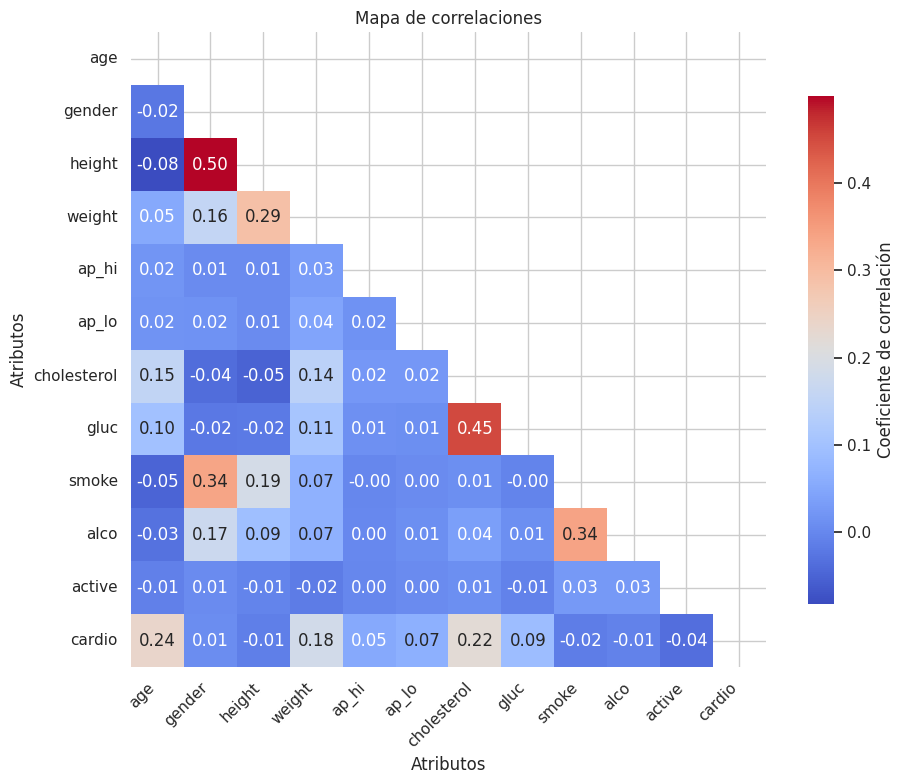

In [29]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"label": "Coeficiente de correlación", "shrink": 0.8},
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Mapa de correlaciones")
plt.xlabel("Atributos")
plt.ylabel("Atributos")
plt.tight_layout()
plt.show()

In [30]:
column_labels = {
  "age": "Age (days)",
  "gender": "Gender / Sex",
  "height": "Height",
  "weight": "Weight",
  "ap_hi": "Systolic blood pressure (mm Hg)",
  "ap_lo": "Diastolic blood pressure (mm Hg)",
  "cholesterol": "Cholesterol level (categorical 1–3)",
  "gluc": "Glucose level (categorical 1–3)",
  "smoke": "Smoking status (0/1)",
  "alco": "Alcohol intake (0/1)",
  "active": "Physical activity (0/1)",
  "cardio": "Cardiovascular disease presence (target 0/1)"
}


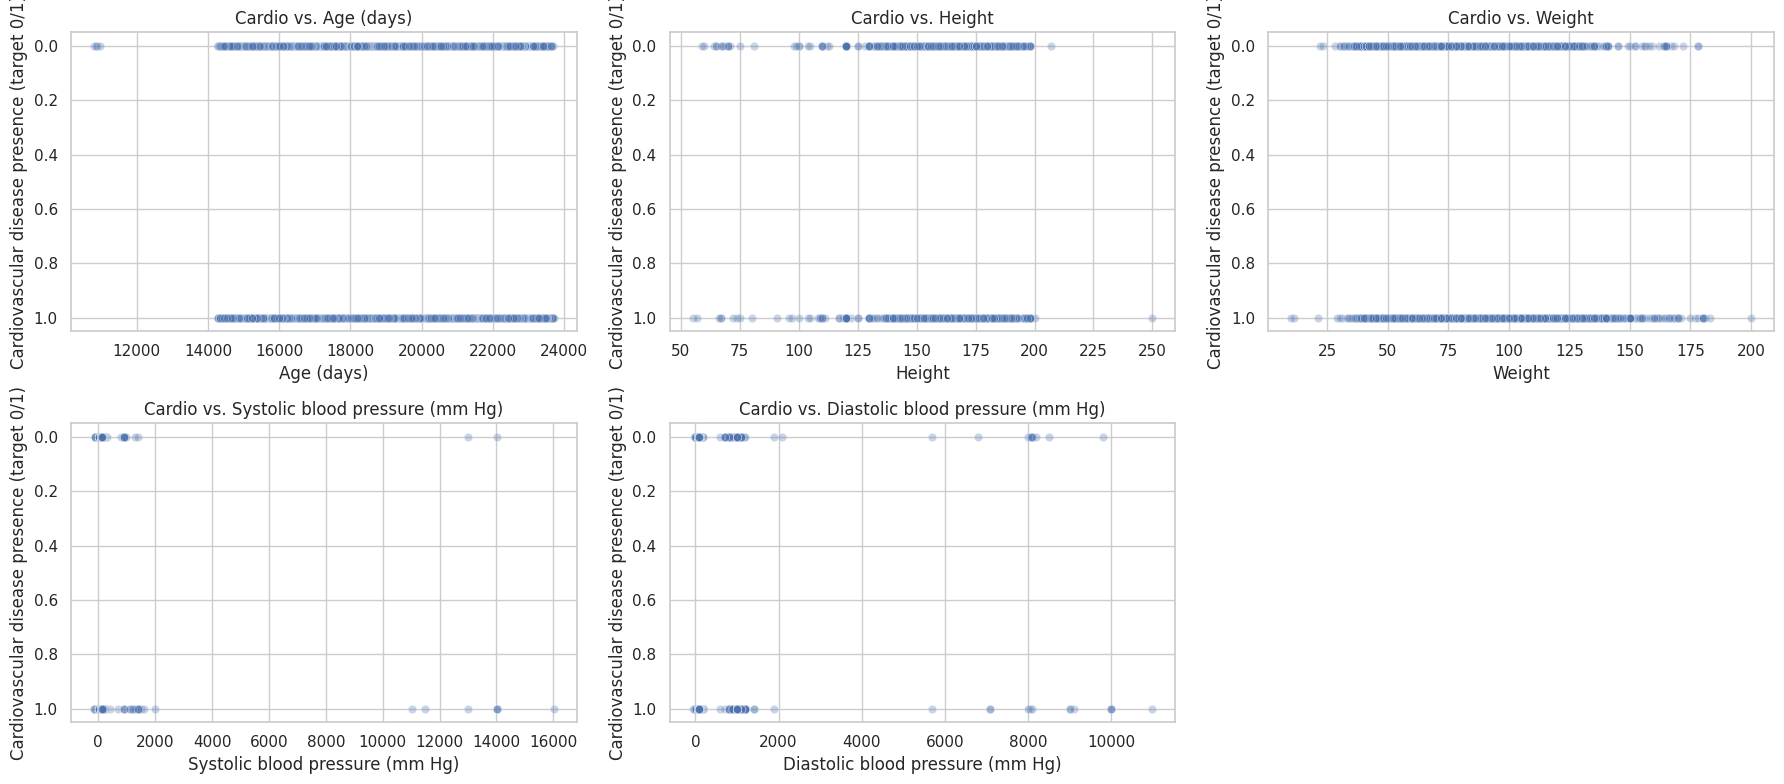

In [31]:
num_cols = df.select_dtypes(include="number").columns
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.scatterplot(x=col, y="cardio", data=df, alpha=0.3, ax=ax)
    ax.set_title(f"Cardio vs. {column_labels.get(col, col)}")
    ax.set_xlabel(column_labels.get(col, col))
    ax.set_ylabel(column_labels["cardio"])
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
plt.tight_layout()
plt.show()

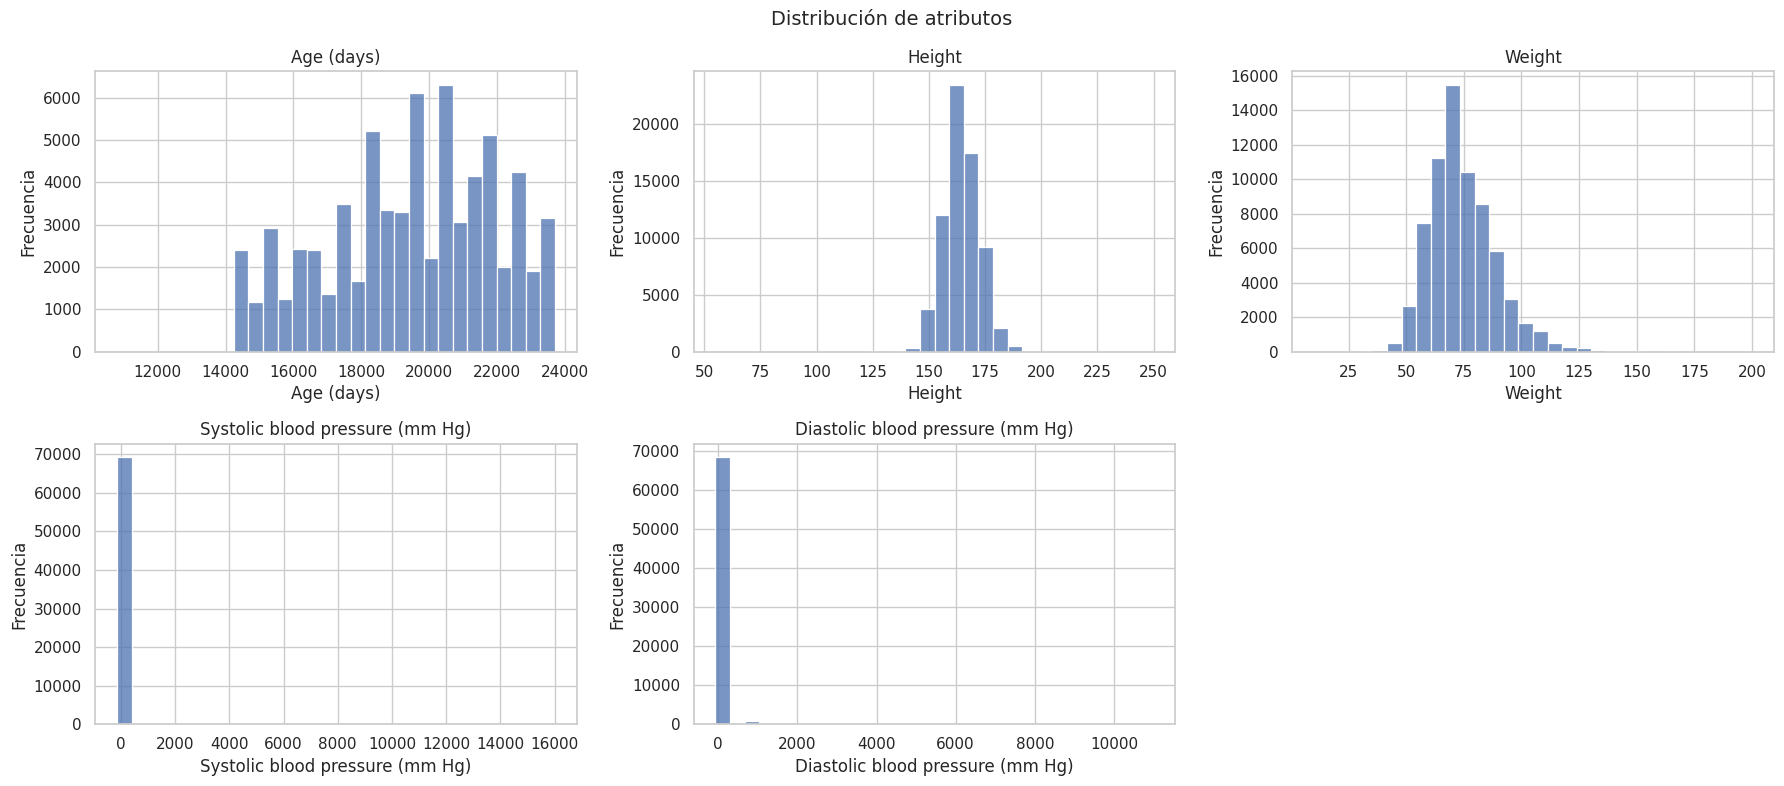

In [34]:
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.histplot(x=df[col], bins=30, ax=ax, stat="count", color="#4C72B0", edgecolor="white")
    label = column_labels.get(col, col)
    ax.set_title(label)
    ax.set_xlabel(label)
    ax.set_ylabel("Frecuencia")
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
fig.suptitle("Distribución de atributos", fontsize=14)
fig.tight_layout()
plt.show()

In [37]:
df['ap_hi'] = df['ap_hi'].clip(lower=70, upper=250)
df['ap_lo'] = df['ap_lo'].clip(lower=40, upper=150)

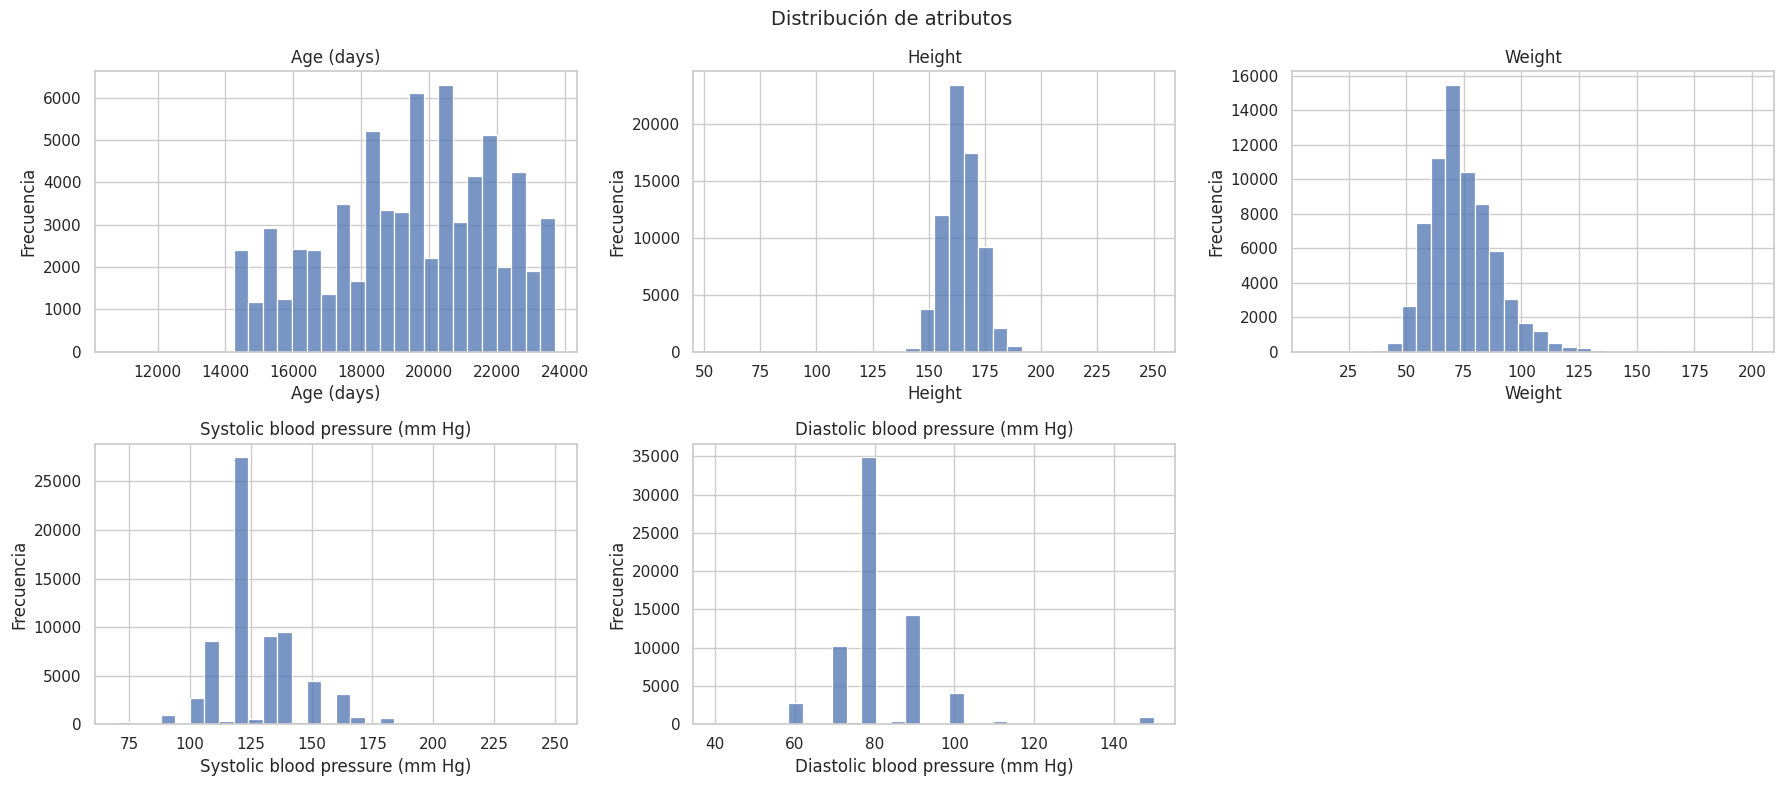

In [38]:
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.histplot(x=df[col], bins=30, ax=ax, stat="count", color="#4C72B0", edgecolor="white")
    label = column_labels.get(col, col)
    ax.set_title(label)
    ax.set_xlabel(label)
    ax.set_ylabel("Frecuencia")
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
fig.suptitle("Distribución de atributos", fontsize=14)
fig.tight_layout()
plt.show()

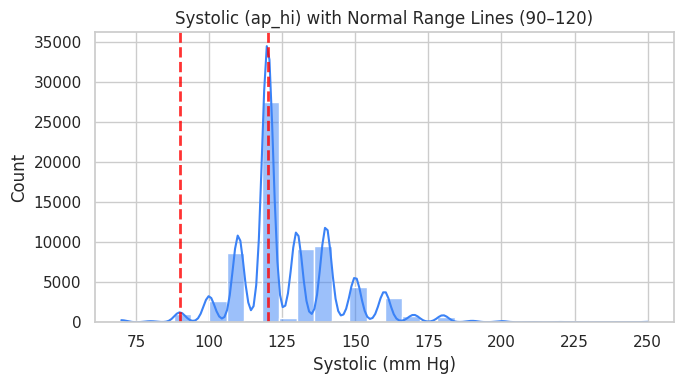

In [39]:

plt.figure(figsize=(7, 4))
ax = sns.histplot(df['ap_hi'], kde=True, color='#3B82F6', bins=30)
for v in (90, 120):
    ax.axvline(v, color='red', linestyle='--', linewidth=2, alpha=0.8)
ax.set_title('Systolic (ap_hi) with Normal Range Lines (90–120)')
ax.set_xlabel('Systolic (mm Hg)')
plt.tight_layout()
plt.show()


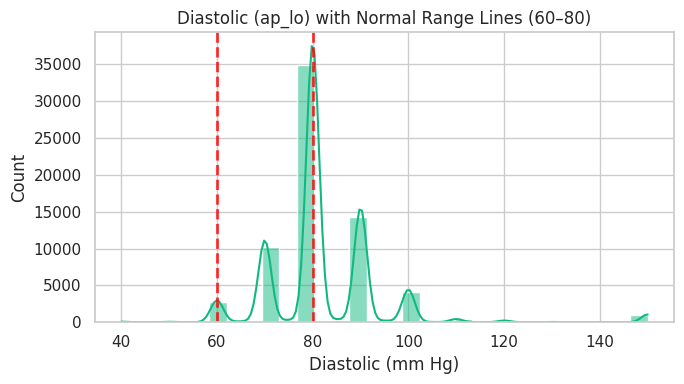

In [41]:

plt.figure(figsize=(7, 4))
ax = sns.histplot(df['ap_lo'], kde=True, color='#10B981', bins=30)
for v in (60, 80):
    ax.axvline(v, color='red', linestyle='--', linewidth=2, alpha=0.8)
ax.set_title('Diastolic (ap_lo) with Normal Range Lines (60–80)')
ax.set_xlabel('Diastolic (mm Hg)')
plt.tight_layout()
plt.show()



LogisticRegression and RandomForest

In [45]:
X = df.drop(columns="cardio",axis=1)
y = df["cardio"]

sss_outer = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(sss_outer.split(X, y))

X_train_full, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train_full, y_test = y.iloc[train_idx], y.iloc[test_idx]

sss_inner = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, val_idx = next(sss_inner.split(X_train_full, y_train_full))

X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

In [46]:
num_cols = [c for c in ["age_years", "height", "weight", "bmi", "ap_hi", "ap_lo"] if c in X.columns]
cat_cols = [c for c in ["gender", "cholesterol", "gluc", "smoke", "alco", "active"] if c in X.columns]


numeric_preprocess = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_preprocess = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, num_cols),
        ("cat", categorical_preprocess, cat_cols),
    ],
    remainder="drop"  # change to 'passthrough' if you want to keep untouched columns
)

In [47]:
preprocess.fit(X_train)

# Transform each split (returns DataFrames if transform_output='pandas' is set)
X_train_pre = preprocess.transform(X_train)
X_val_pre   = preprocess.transform(X_val)
X_test_pre  = preprocess.transform(X_test)

print("Train prepared:", X_train_pre.shape)
print("Valid prepared:", X_val_pre.shape)
print("Test  prepared:", X_test_pre.shape)

Train prepared: (41565, 14)
Valid prepared: (13856, 14)
Test  prepared: (13856, 14)


#### Programación del diseño experimental.

LogisticRegression — Validation
Accuracy: 0.7283487297921478
F1     : 0.7059834400874864
ROC AUC: 0.7823965997654152
              precision    recall  f1-score   support

           0     0.6986    0.8038    0.7476      6933
           1     0.7687    0.6528    0.7060      6923

    accuracy                         0.7283     13856
   macro avg     0.7337    0.7283    0.7268     13856
weighted avg     0.7336    0.7283    0.7268     13856

Best threshold by Youden’s J (val): 0.514269949722023

LogisticRegression — Test
Accuracy: 0.7245236720554272
F1     : 0.6973277297597336
ROC AUC: 0.7734524141314281
              precision    recall  f1-score   support

           0     0.6907    0.8138    0.7472      6933
           1     0.7730    0.6351    0.6973      6923

    accuracy                         0.7245     13856
   macro avg     0.7319    0.7245    0.7223     13856
weighted avg     0.7319    0.7245    0.7223     13856

Confusion matrix (test):
 [[5642 1291]
 [2526 4397]]


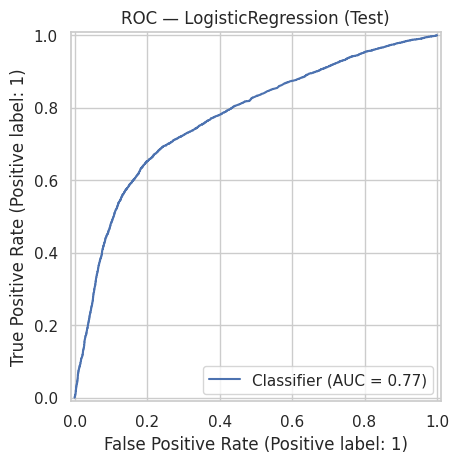

In [49]:
# Train
lr = LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs", n_jobs=None)
lr.fit(X_train_pre, y_train)

# Validate
val_proba = lr.predict_proba(X_val_pre)[:, 1]
val_pred  = (val_proba >= 0.5).astype(int)
print("LogisticRegression — Validation")
print("Accuracy:", accuracy_score(y_val, val_pred))
print("F1     :", f1_score(y_val, val_pred))
print("ROC AUC:", roc_auc_score(y_val, val_proba))
print(classification_report(y_val, val_pred, digits=4))

# Choose a threshold on validation if you want (optional)
# Example: Youden’s J to maximize (TPR - FPR)
from sklearn.metrics import roc_curve
fpr, tpr, thr = roc_curve(y_val, val_proba)
best_idx = np.argmax(tpr - fpr)
best_thr = thr[best_idx]
print("Best threshold by Youden’s J (val):", float(best_thr))

# Test
test_proba = lr.predict_proba(X_test_pre)[:, 1]
test_pred  = (test_proba >= best_thr).astype(int)  # or 0.5 if you prefer
print("\nLogisticRegression — Test")
print("Accuracy:", accuracy_score(y_test, test_pred))
print("F1     :", f1_score(y_test, test_pred))
print("ROC AUC:", roc_auc_score(y_test, test_proba))
print(classification_report(y_test, test_pred, digits=4))

# Confusion matrix (test)
cm = confusion_matrix(y_test, test_pred)
print("Confusion matrix (test):\n", cm)

# ROC curve (test)
RocCurveDisplay.from_predictions(y_test, test_proba)
plt.title("ROC — LogisticRegression (Test)")
plt.show()

RandomForest — Validation
Accuracy: 0.6907476905311778
F1     : 0.6825690791910511
ROC AUC: 0.7353372623575493
              precision    recall  f1-score   support

           0     0.6819    0.7160    0.6985      6933
           1     0.7006    0.6655    0.6826      6923

    accuracy                         0.6907     13856
   macro avg     0.6912    0.6907    0.6905     13856
weighted avg     0.6912    0.6907    0.6905     13856

Best threshold by Youden’s J (val): 0.5132896012614855

RandomForest — Test
Accuracy: 0.6835306004618937
F1     : 0.6703255394331253
ROC AUC: 0.7283825278075313
              precision    recall  f1-score   support

           0     0.6704    0.7231    0.6957      6933
           1     0.6990    0.6439    0.6703      6923

    accuracy                         0.6835     13856
   macro avg     0.6847    0.6835    0.6830     13856
weighted avg     0.6847    0.6835    0.6830     13856

Confusion matrix (test):
 [[5013 1920]
 [2465 4458]]


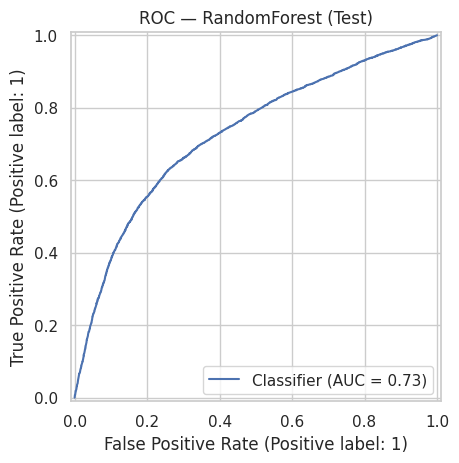


Top importances:
 num__weight           0.294608
num__height           0.265298
num__ap_hi            0.222806
num__ap_lo            0.113279
cat__cholesterol_3    0.020513
cat__cholesterol_1    0.019848
cat__active_1         0.013600
cat__gender_2         0.013586
cat__smoke_1          0.009151
cat__alco_1           0.008106
cat__gluc_1           0.005862
cat__cholesterol_2    0.005386
cat__gluc_3           0.004245
cat__gluc_2           0.003713
dtype: float64


In [51]:

# Train
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"  # helps when classes are imbalanced
)
rf.fit(X_train_pre, y_train)

# Validate
val_proba = rf.predict_proba(X_val_pre)[:, 1]
val_pred  = (val_proba >= 0.5).astype(int)
print("RandomForest — Validation")
print("Accuracy:", accuracy_score(y_val, val_pred))
print("F1     :", f1_score(y_val, val_pred))
print("ROC AUC:", roc_auc_score(y_val, val_proba))
print(classification_report(y_val, val_pred, digits=4))

# Threshold tuning on validation (optional)
from sklearn.metrics import roc_curve
import numpy as np
fpr, tpr, thr = roc_curve(y_val, val_proba)
best_idx = np.argmax(tpr - fpr)
best_thr = thr[best_idx]
print("Best threshold by Youden’s J (val):", float(best_thr))

# Test
test_proba = rf.predict_proba(X_test_pre)[:, 1]
test_pred  = (test_proba >= best_thr).astype(int)
print("\nRandomForest — Test")
print("Accuracy:", accuracy_score(y_test, test_pred))
print("F1     :", f1_score(y_test, test_pred))
print("ROC AUC:", roc_auc_score(y_test, test_proba))
print(classification_report(y_test, test_pred, digits=4))

# Confusion matrix (test)
cm = confusion_matrix(y_test, test_pred)
print("Confusion matrix (test):\n", cm)

# ROC curve (test)
RocCurveDisplay.from_predictions(y_test, test_proba)
plt.title("ROC — RandomForest (Test)")
plt.show()

# (Optional) Feature importance with column names
# If X_train_pre is a DataFrame (sklearn >= 1.2 with transform_output='pandas'), this works:
import pandas as pd
if hasattr(X_train_pre, "columns"):
    fi = pd.Series(rf.feature_importances_, index=X_train_pre.columns).sort_values(ascending=False)
    print("\nTop importances:\n", fi.head(20))


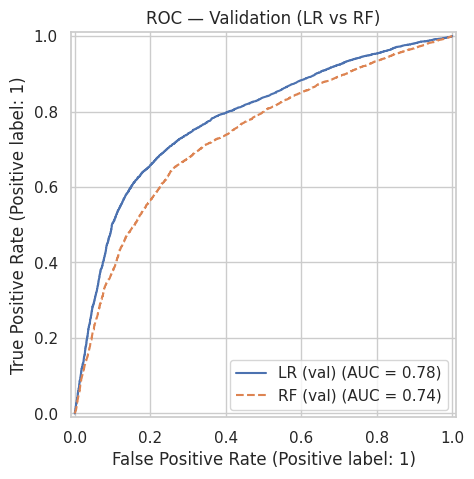

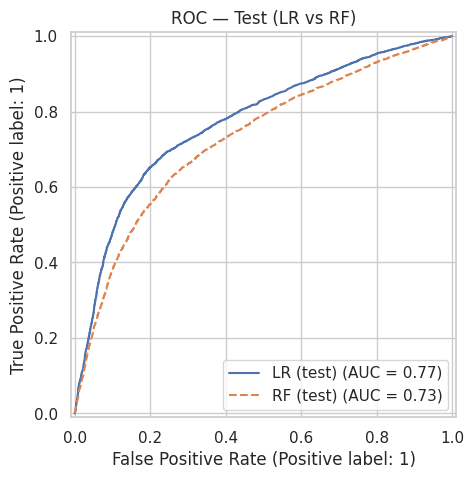

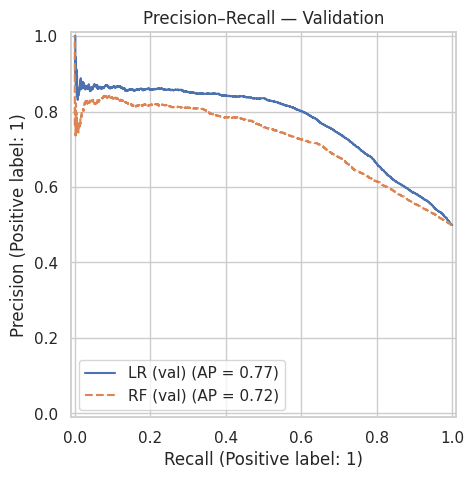

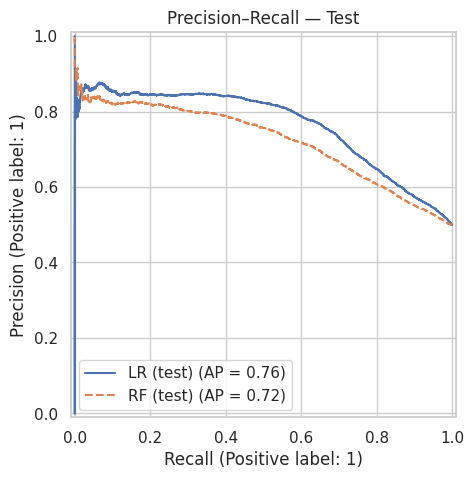

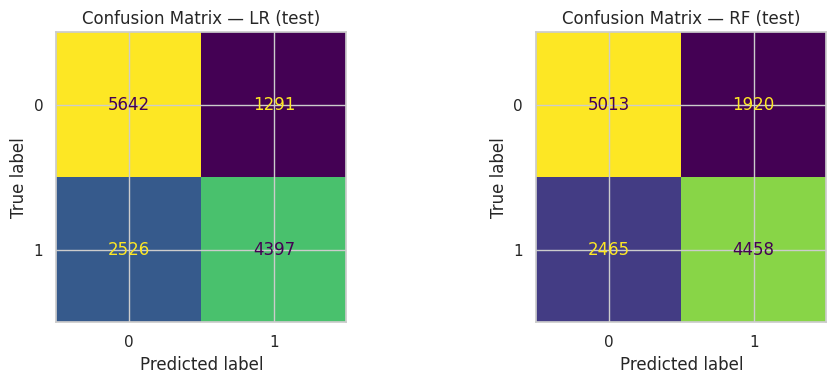

In [54]:
# Probabilities
val_proba_lr = lr.predict_proba(X_val_pre)[:, 1]
val_proba_rf = rf.predict_proba(X_val_pre)[:, 1]
test_proba_lr = lr.predict_proba(X_test_pre)[:, 1]
test_proba_rf = rf.predict_proba(X_test_pre)[:, 1]

# ROC — Validation
fig, ax = plt.subplots(figsize=(6.5, 5))
RocCurveDisplay.from_predictions(y_val, val_proba_lr, name="LR (val)", ax=ax)
RocCurveDisplay.from_predictions(y_val, val_proba_rf, name="RF (val)", ax=ax, linestyle="--")
plt.title("ROC — Validation (LR vs RF)")
plt.show()

# ROC — Test
fig, ax = plt.subplots(figsize=(6.5, 5))
RocCurveDisplay.from_predictions(y_test, test_proba_lr, name="LR (test)", ax=ax)
RocCurveDisplay.from_predictions(y_test, test_proba_rf, name="RF (test)", ax=ax, linestyle="--")
plt.title("ROC — Test (LR vs RF)")
plt.show()

# PR — Validation & Test
from sklearn.metrics import PrecisionRecallDisplay
fig, ax = plt.subplots(figsize=(6.5, 5))
PrecisionRecallDisplay.from_predictions(y_val, val_proba_lr, name="LR (val)", ax=ax)
PrecisionRecallDisplay.from_predictions(y_val, val_proba_rf, name="RF (val)", ax=ax, linestyle="--")
plt.title("Precision–Recall — Validation")
plt.show()

fig, ax = plt.subplots(figsize=(6.5, 5))
PrecisionRecallDisplay.from_predictions(y_test, test_proba_lr, name="LR (test)", ax=ax)
PrecisionRecallDisplay.from_predictions(y_test, test_proba_rf, name="RF (test)", ax=ax, linestyle="--")
plt.title("Precision–Recall — Test")
plt.show()

# Thresholds from validation (Youden’s J)
fpr_lr, tpr_lr, thr_lr = roc_curve(y_val, val_proba_lr)
fpr_rf, tpr_rf, thr_rf = roc_curve(y_val, val_proba_rf)
thr_best_lr = thr_lr[np.argmax(tpr_lr - fpr_lr)]
thr_best_rf = thr_rf[np.argmax(tpr_rf - fpr_rf)]

# Confusion matrices on Test
test_pred_lr = (test_proba_lr >= thr_best_lr).astype(int)
test_pred_rf = (test_proba_rf >= thr_best_rf).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(confusion_matrix(y_test, test_pred_lr)).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix — LR (test)")
ConfusionMatrixDisplay(confusion_matrix(y_test, test_pred_rf)).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix — RF (test)")
plt.tight_layout()
plt.show()